## Load and apply inference models
This notebook loads trained inference models from the outputs of `cmass.infer.train`, plots their prediction performance, and applies them to new test data.

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import pickle
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


## Load a model and plot test predictions

In [3]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']
hodnames = [r'$\alpha$', r'$\log M_0$', r'$\log M_1$',
            r'$\log M_{\min}$', r'$\sigma_{\log M}$']
names = cosmonames+hodnames

# Specify model configuration
nbody = 'mtnglike'
sim = 'fastpm'
save_dir = join(wdir, nbody, sim, 'models')

In [4]:
# Specify data dtype
tracer = 'ngc_lightcone'
summaries = ['Pk0', 'Pk2']
summary = '+'.join(summaries)
kmax = 0.3
modelpath = join(save_dir, tracer, summary, f'kmax-{kmax}')
os.listdir(modelpath)

['posterior.pkl',
 'loss.jpg',
 'true_logprobs.npy',
 'theta_train.npy',
 'plot_coverage.jpg',
 'theta_test.npy',
 'x_test.npy',
 'plot_true_logprobs.jpg',
 'ranks_histogram.jpg',
 'plot_single_posterior.jpg',
 'x_train.npy',
 'plot_TARP.jpg',
 'summary.json',
 'plot_predictions.jpg',
 'posterior_samples.npy']

(-5.0, 15.0)

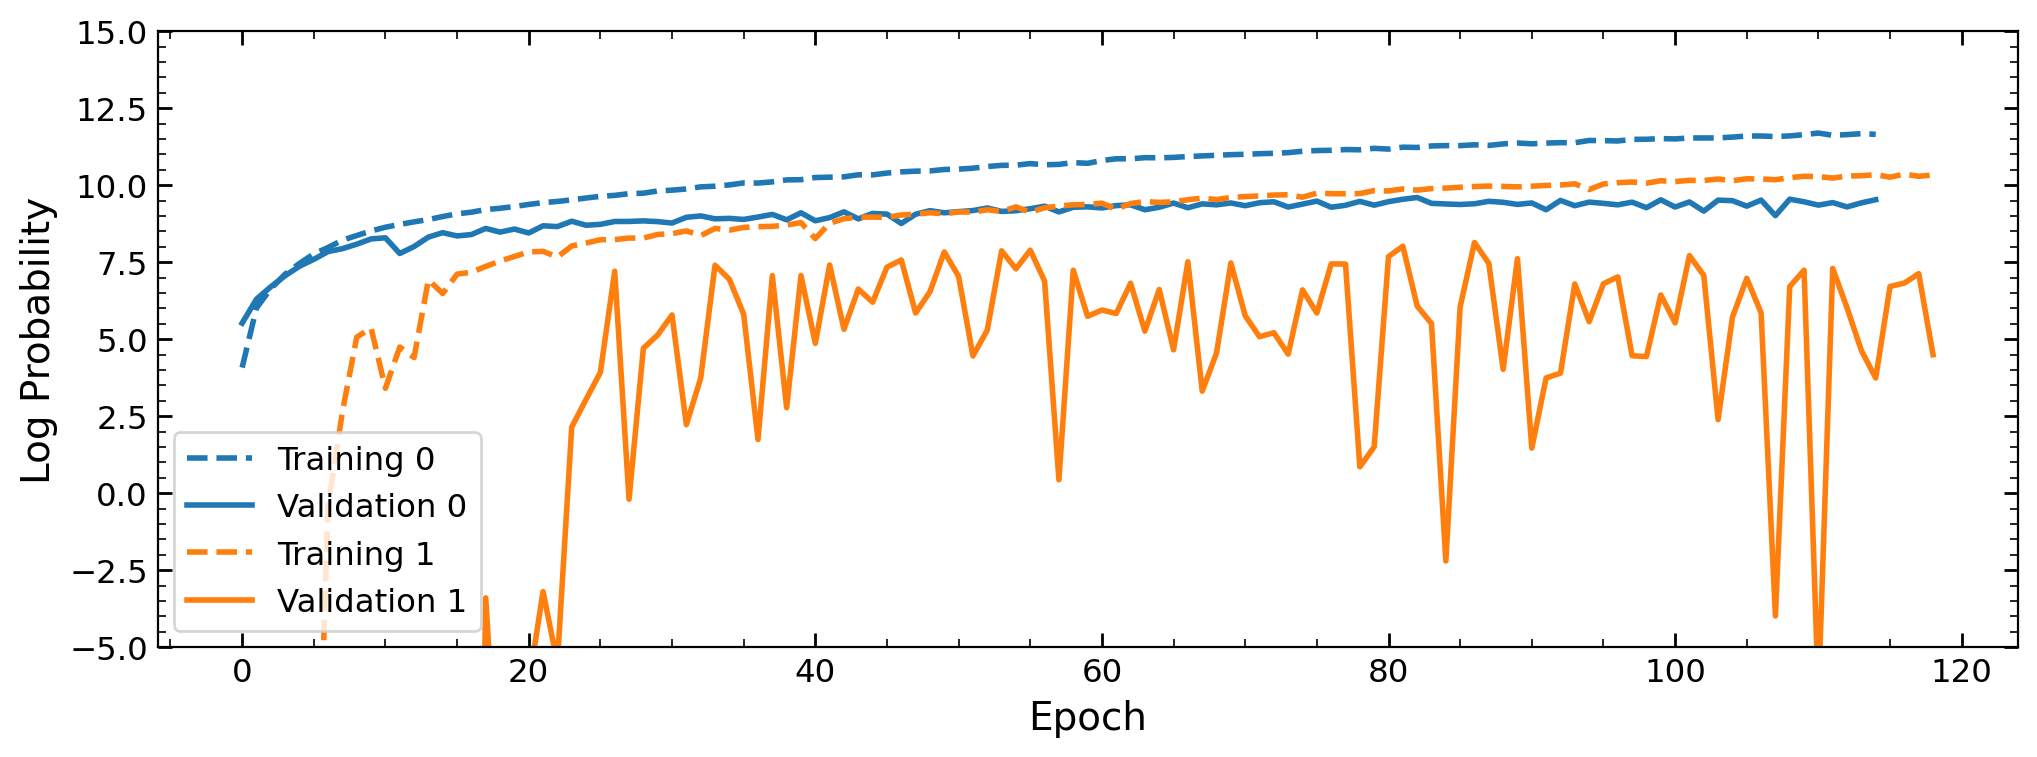

In [103]:
# Load training history
summary_file = join(modelpath, 'summary.json')
with open(summary_file, 'r') as f:
    history = json.load(f)
f, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(len(history)):
    ax.plot(history[i]['training_log_probs'],
            label=f'Training {i}', c=f'C{i}', ls='--')
    ax.plot(history[i]['validation_log_probs'],
            label=f'Validation {i}', c=f'C{i}')
ax.set(xlabel='Epoch', ylabel='Log Probability')
ax.legend()
ax.set_ylim(-5, 15)

In [6]:
# Load predictions
xtest = np.load(join(modelpath, 'x_test.npy'))
ytest = np.load(join(modelpath, 'theta_test.npy'))
samps = np.load(join(modelpath, 'posterior_samples.npy'))
percs = np.percentile(samps, [16, 50, 84], axis=0)

yrange = np.stack([
    ytest.min(axis=0),
    ytest.max(axis=0)
], axis=1)

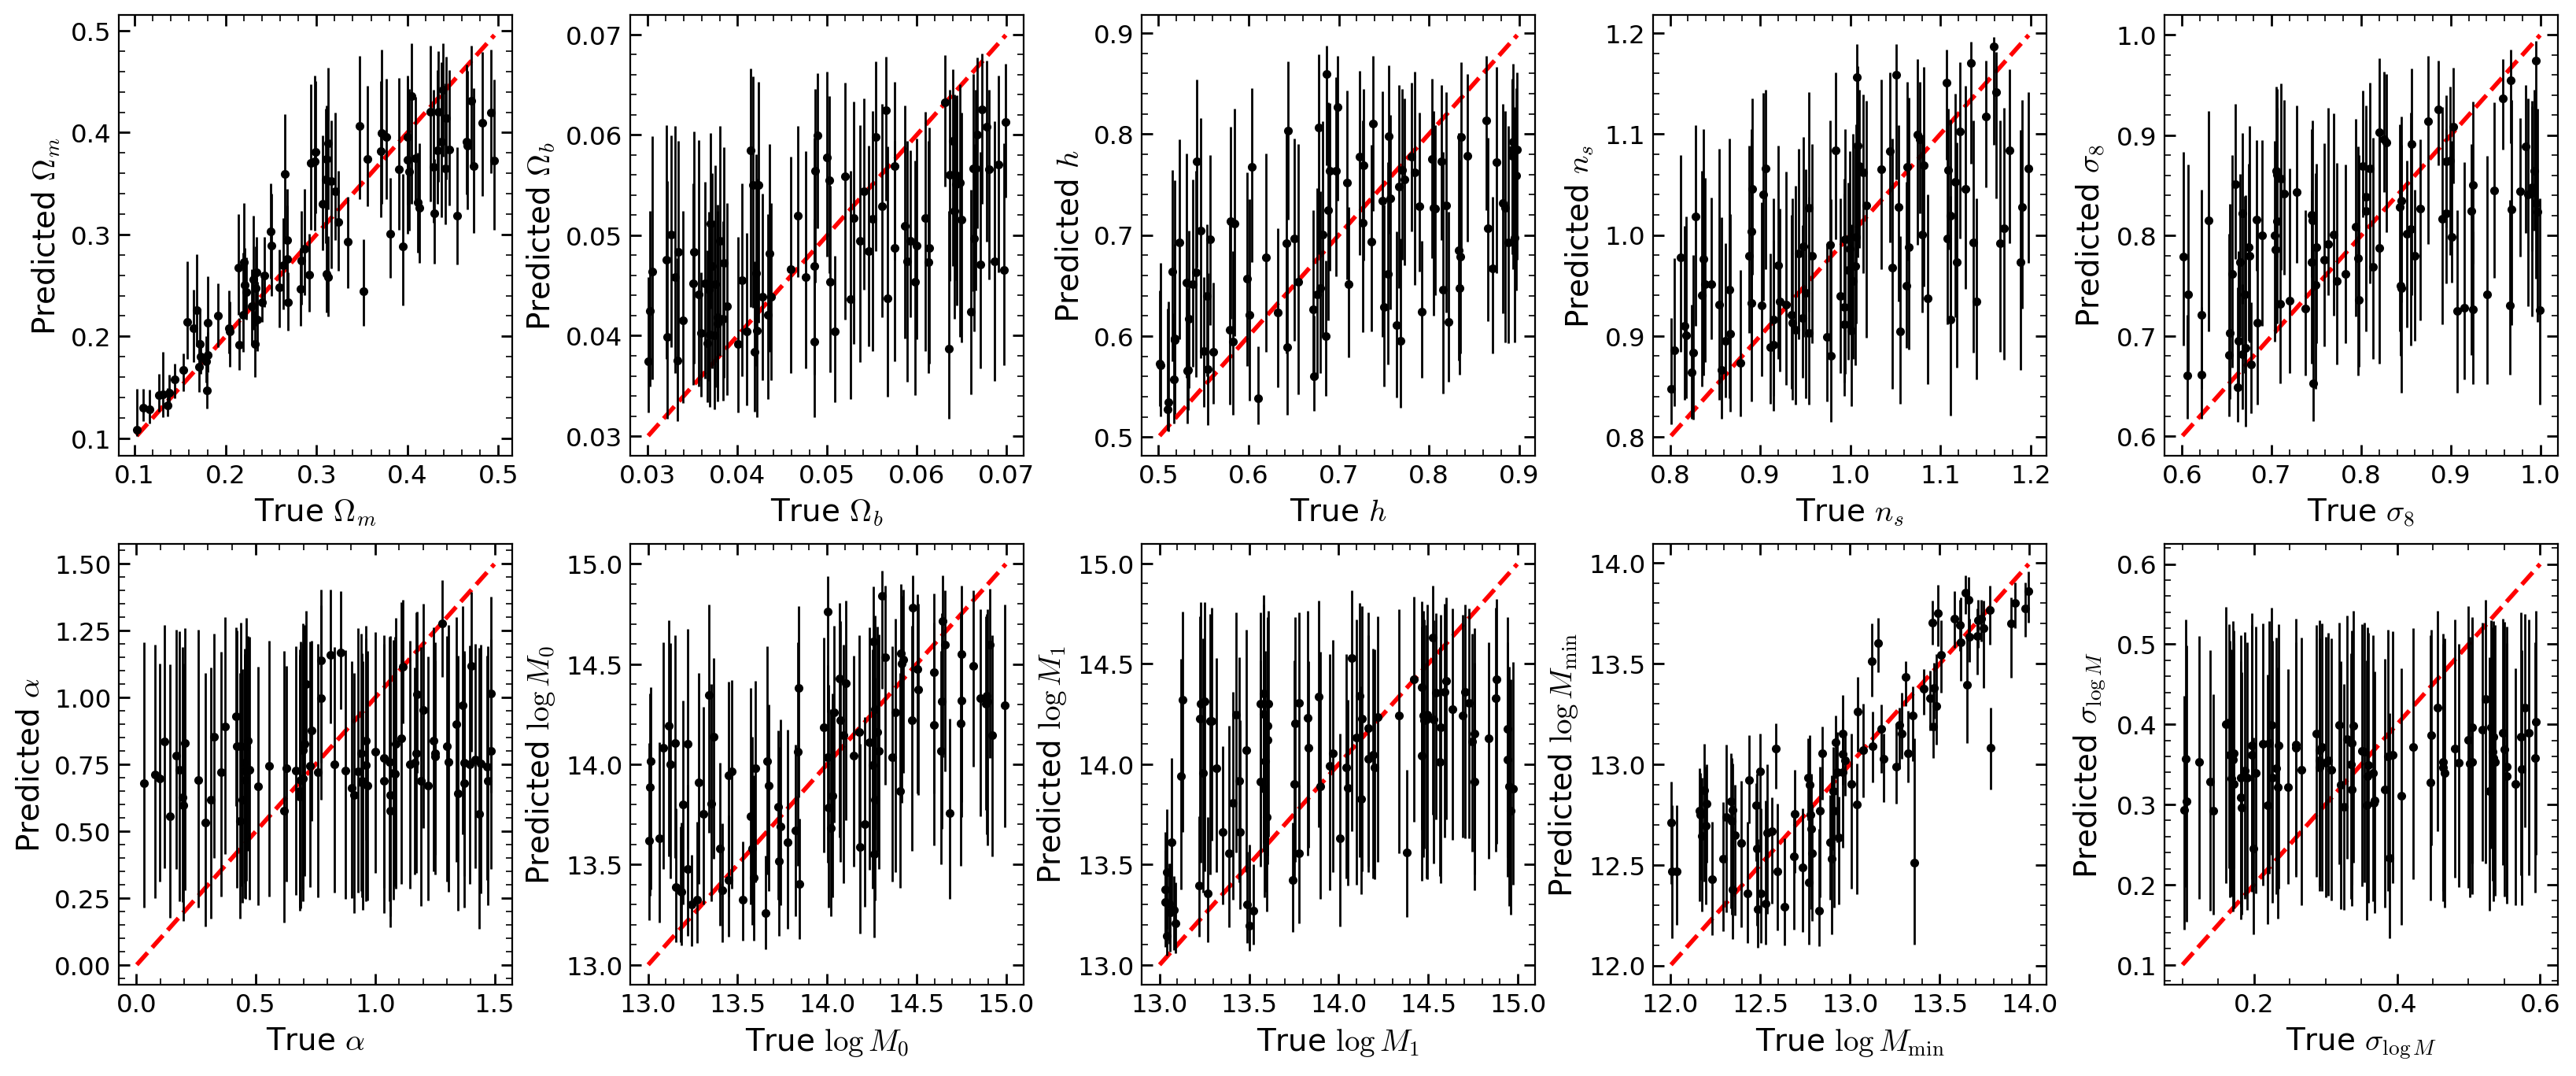

In [7]:

ss = 10

N = len(names)
f, axs = plt.subplots(2, N//2, figsize=(20, 8), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.plot(yrange[i], yrange[i], 'r--')
    ax.plot(ytest[::ss, i], percs[1, ::ss, i], 'k.')
    ax.errorbar(ytest[::ss, i], percs[1, ::ss, i], yerr=[percs[1, ::ss, i]-percs[0, ::ss, i],
                percs[2, ::ss, i]-percs[1, ::ss, i]], fmt='none', ecolor='k', elinewidth=1)
    ax.set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')

In [8]:
# these functions load pickled torch modules
# if the model was trained on GPU, this will ensure safe loading to CPU
# TODO: update ltu-ili so this is already handled...

import torch
import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)


def load_posterior(modeldir):
    with open(join(modeldir, 'posterior.pkl'), 'rb') as f:
        ensemble = CPU_Unpickler(f).load()
    ensemble = ensemble.to(device)
    for p in ensemble.posteriors:
        p.to(device)
    return ensemble


posterior = load_posterior(modelpath)

INFO:root:Sampling models with [1624, 376] samples each.
Drawing 1624 posterior samples: 1860it [00:01, 1446.32it/s]                        
Drawing 376 posterior samples: 462it [00:00, 10675.18it/s]            


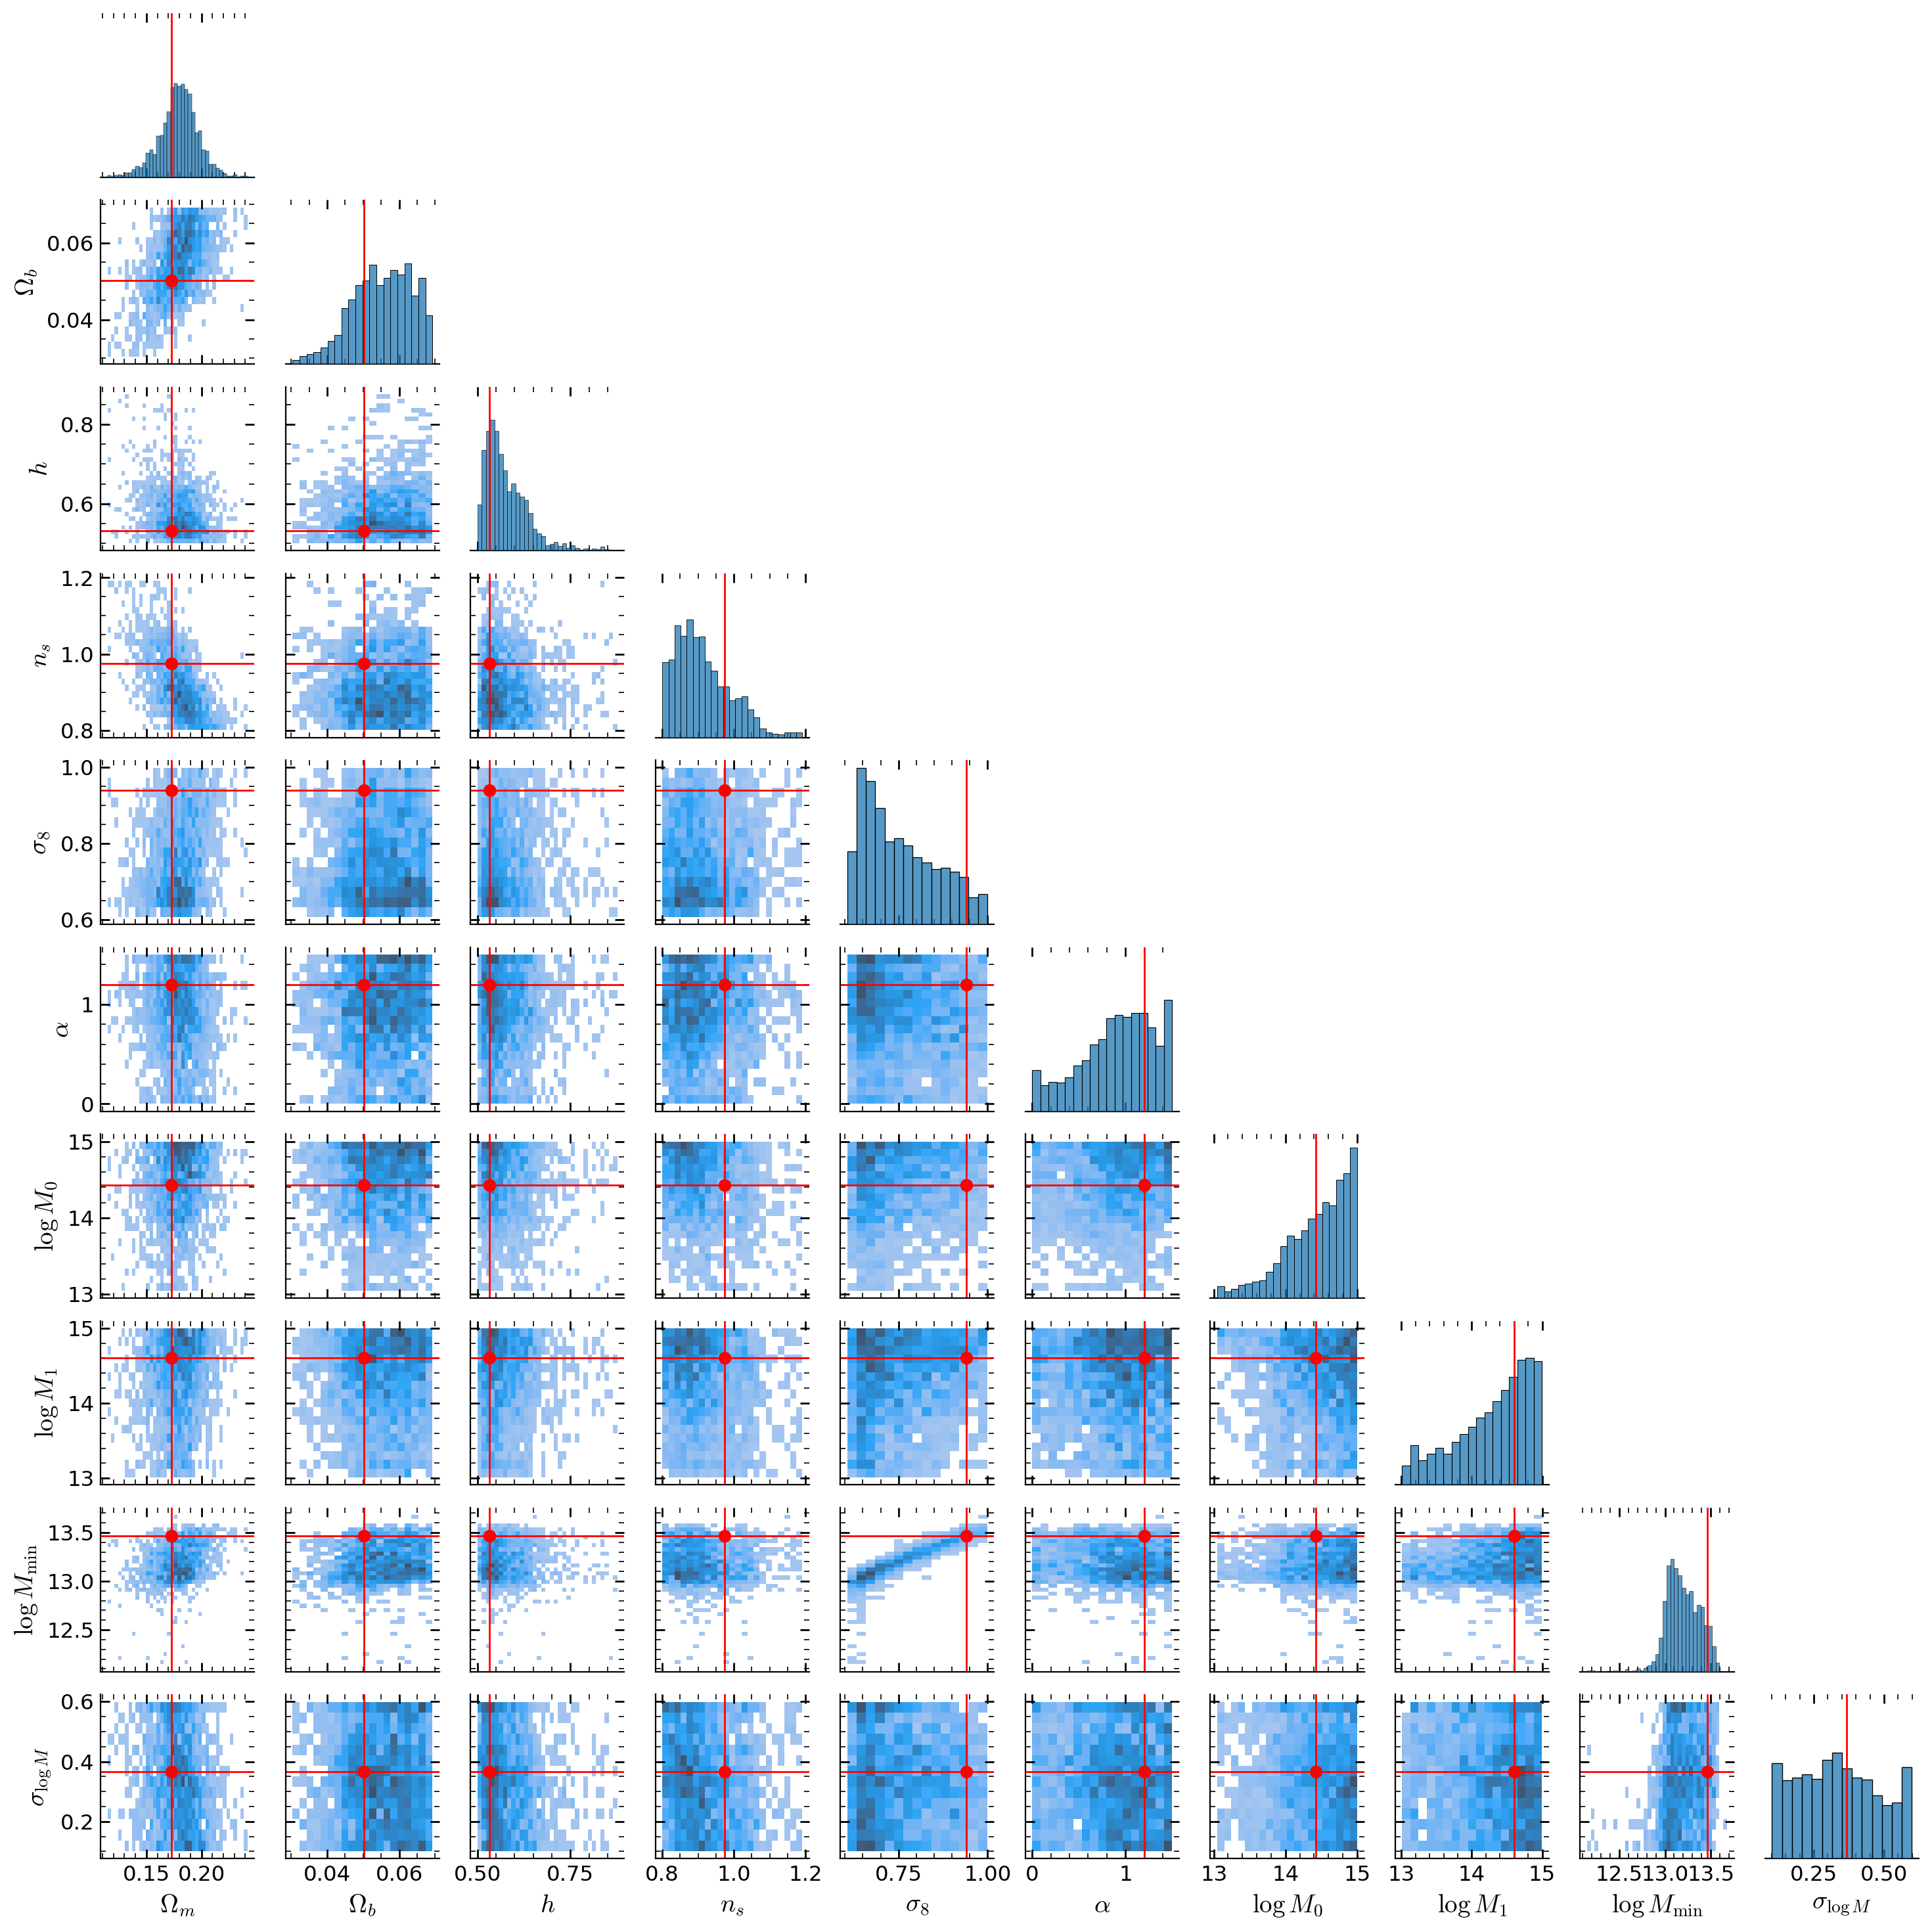

In [9]:
# Predict on a random test point
ind = 10
x0 = torch.Tensor(xtest[ind]).to(device)
y0 = ytest[ind]
samp0 = posterior.sample(x=x0, shape=(2000,))
samp0 = pd.DataFrame(samp0, columns=names)


def plot_true_vals(grid, true_vals, **kwargs):
    for i, val in enumerate(true_vals):
        grid.diag_axes[i].axvline(val, **kwargs)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.axvline(true_vals[j], **kwargs)
                ax.axhline(val, **kwargs)
                ax.plot(true_vals[j], val, 'o', **kwargs)


g = sns.pairplot(
    samp0,
    vars=names,
    kind='hist',
    corner=True,
    height=1.5
    # plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True},  # for kde plot
)

plot_true_vals(g, y0, color='r', lw=1)

## Load an observed summary and predict

In [10]:
# Load an observed summary
nbody = 'quijote3gpch'
sim = 'nbody'
L, N = 3000, 384
lhid = 2000
# summaries = ['Pk0', 'Pk2']

simpath = join(wdir, nbody, sim, f'L{L}-N{N}', f'{lhid}', 'diag')

summ = {}
with h5py.File(join(simpath, 'ngc_lightcone/hod20003_aug00000.h5'), 'r') as f:
    k = f['Pk_k3D'][:]
    for s in ['Pk0', 'Pk2', 'Pk4']:
        if s[:2] != 'Pk':
            raise NotImplementedError
        Pk = f['Pk'][:, int(s[-1])//2]  # get the pole
        summ[s] = [{'k': k, 'value': Pk}]

    truecosmo = f.attrs['cosmo_params']
    truehod = f.attrs['HOD_params']
    trueparams = np.concatenate([truecosmo, truehod])

# truecosmo = [0.3175, 0.04900, 0.6711, 0.9624, 0.834]

In [11]:
trueparams

array([ 0.3175    ,  0.049     ,  0.6711    ,  0.9624    ,  0.834     ,
        1.04958903, 13.38268183, 14.21876213, 12.94525188,  0.14586841])

In [12]:
# Preprocess the summary
from cmass.infer.loaders import preprocess_Pk
xin = []
for s in summaries:
    if s == 'Pk0':
        xs = preprocess_Pk(summ[s], kmax, monopole=True)
    else:
        xs = preprocess_Pk(summ[s], kmax, monopole=False, norm=summ['Pk0'])
    xin.append(xs)
xin = np.array(xin).flatten()

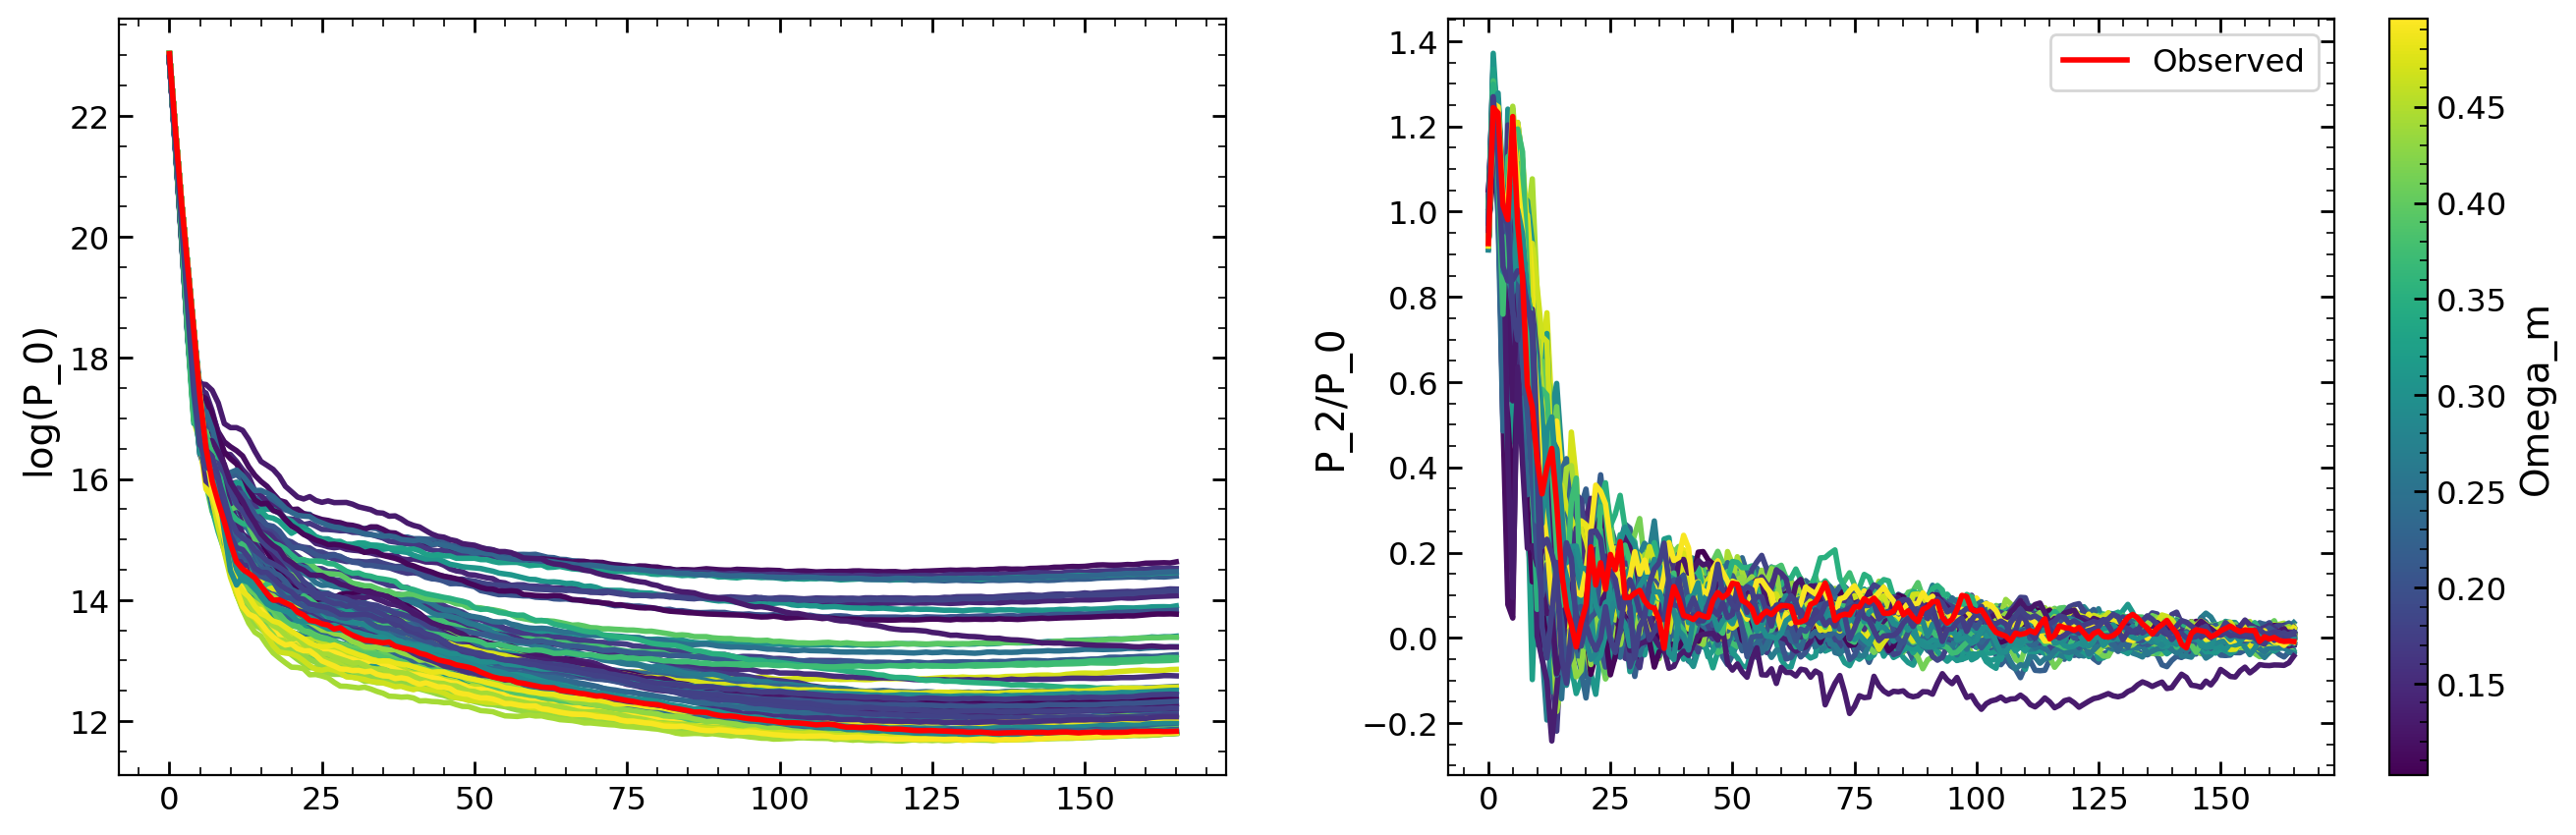

In [13]:
import matplotlib.colors as mcolors

ss = 10
Npoles = len(summaries)

f, axs = plt.subplots(1, Npoles, figsize=(8*Npoles, 5))
if Npoles == 1:
    axs = [axs]
par = ytest[::ss, 0]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=par.min(), vmax=par.max())

for j, ax in enumerate(axs):
    for i, t in enumerate(xtest[::ss]):
        ax.plot(t.reshape(Npoles, -1)[j], color=cmap(norm(par[i])))
    ax.plot(xin.reshape(Npoles, -1)[j], color='r', label='Observed')
    if j == 0:
        ax.set_ylabel(f'log(P_{2*j})')
    else:
        ax.set_ylabel(f'P_{2*j}/P_0')

ax.legend()
plt.colorbar(plt.cm.ScalarMappable(
    cmap=cmap, norm=norm), ax=ax, label='Omega_m')

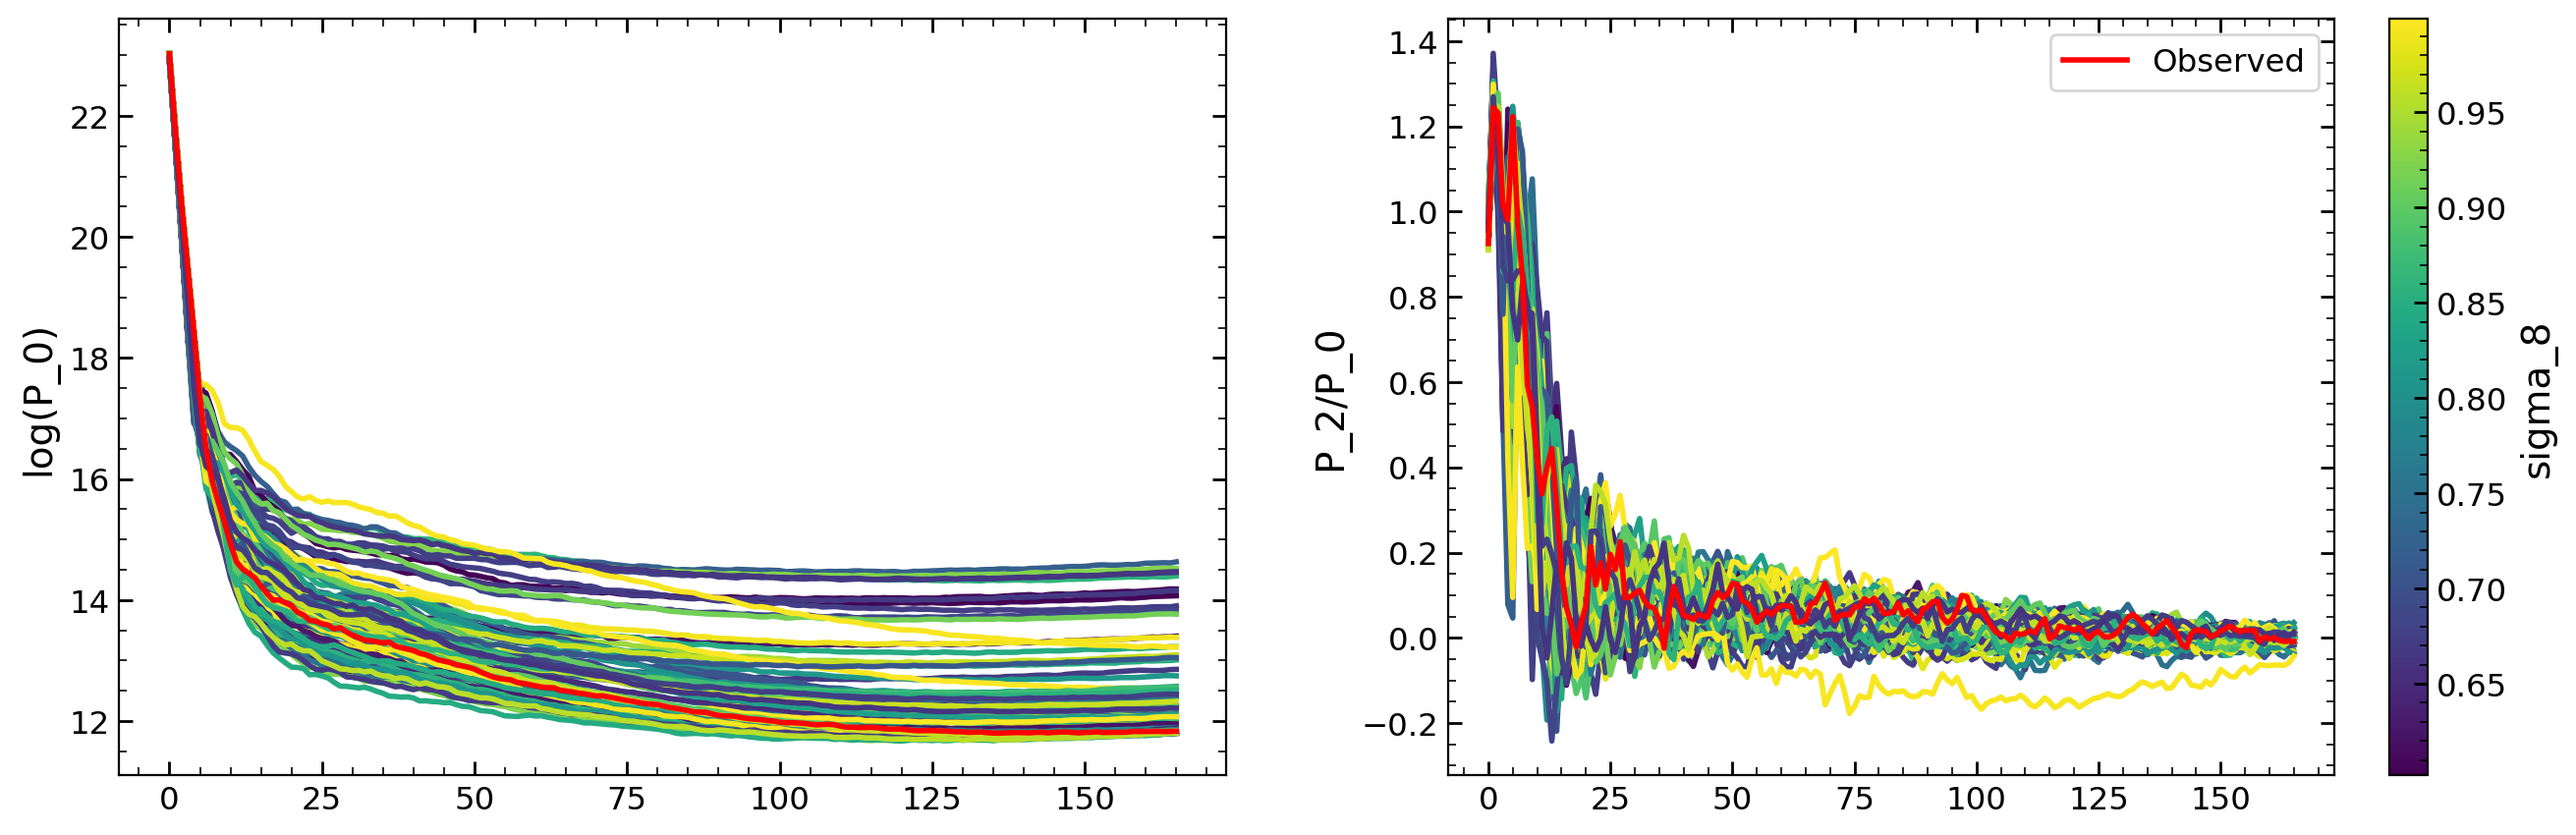

In [14]:
import matplotlib.colors as mcolors

ss = 10
Npoles = len(summaries)

f, axs = plt.subplots(1, Npoles, figsize=(8*Npoles, 5))
par = ytest[::ss, 4]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=par.min(), vmax=par.max())

for j, ax in enumerate(axs):
    for i, t in enumerate(xtest[::ss]):
        ax.plot(t.reshape(Npoles, -1)[j], color=cmap(norm(par[i])))
    ax.plot(xin.reshape(Npoles, -1)[j], color='r', label='Observed')
    if j == 0:
        ax.set_ylabel(f'log(P_{2*j})')
    else:
        ax.set_ylabel(f'P_{2*j}/P_0')

ax.legend()
plt.colorbar(plt.cm.ScalarMappable(
    cmap=cmap, norm=norm), ax=ax, label='sigma_8')

INFO:root:Sampling models with [1624, 376] samples each.
Drawing 1624 posterior samples: 1752it [00:00, 10867.53it/s]            
Drawing 376 posterior samples: 456it [00:00, 15783.81it/s]            


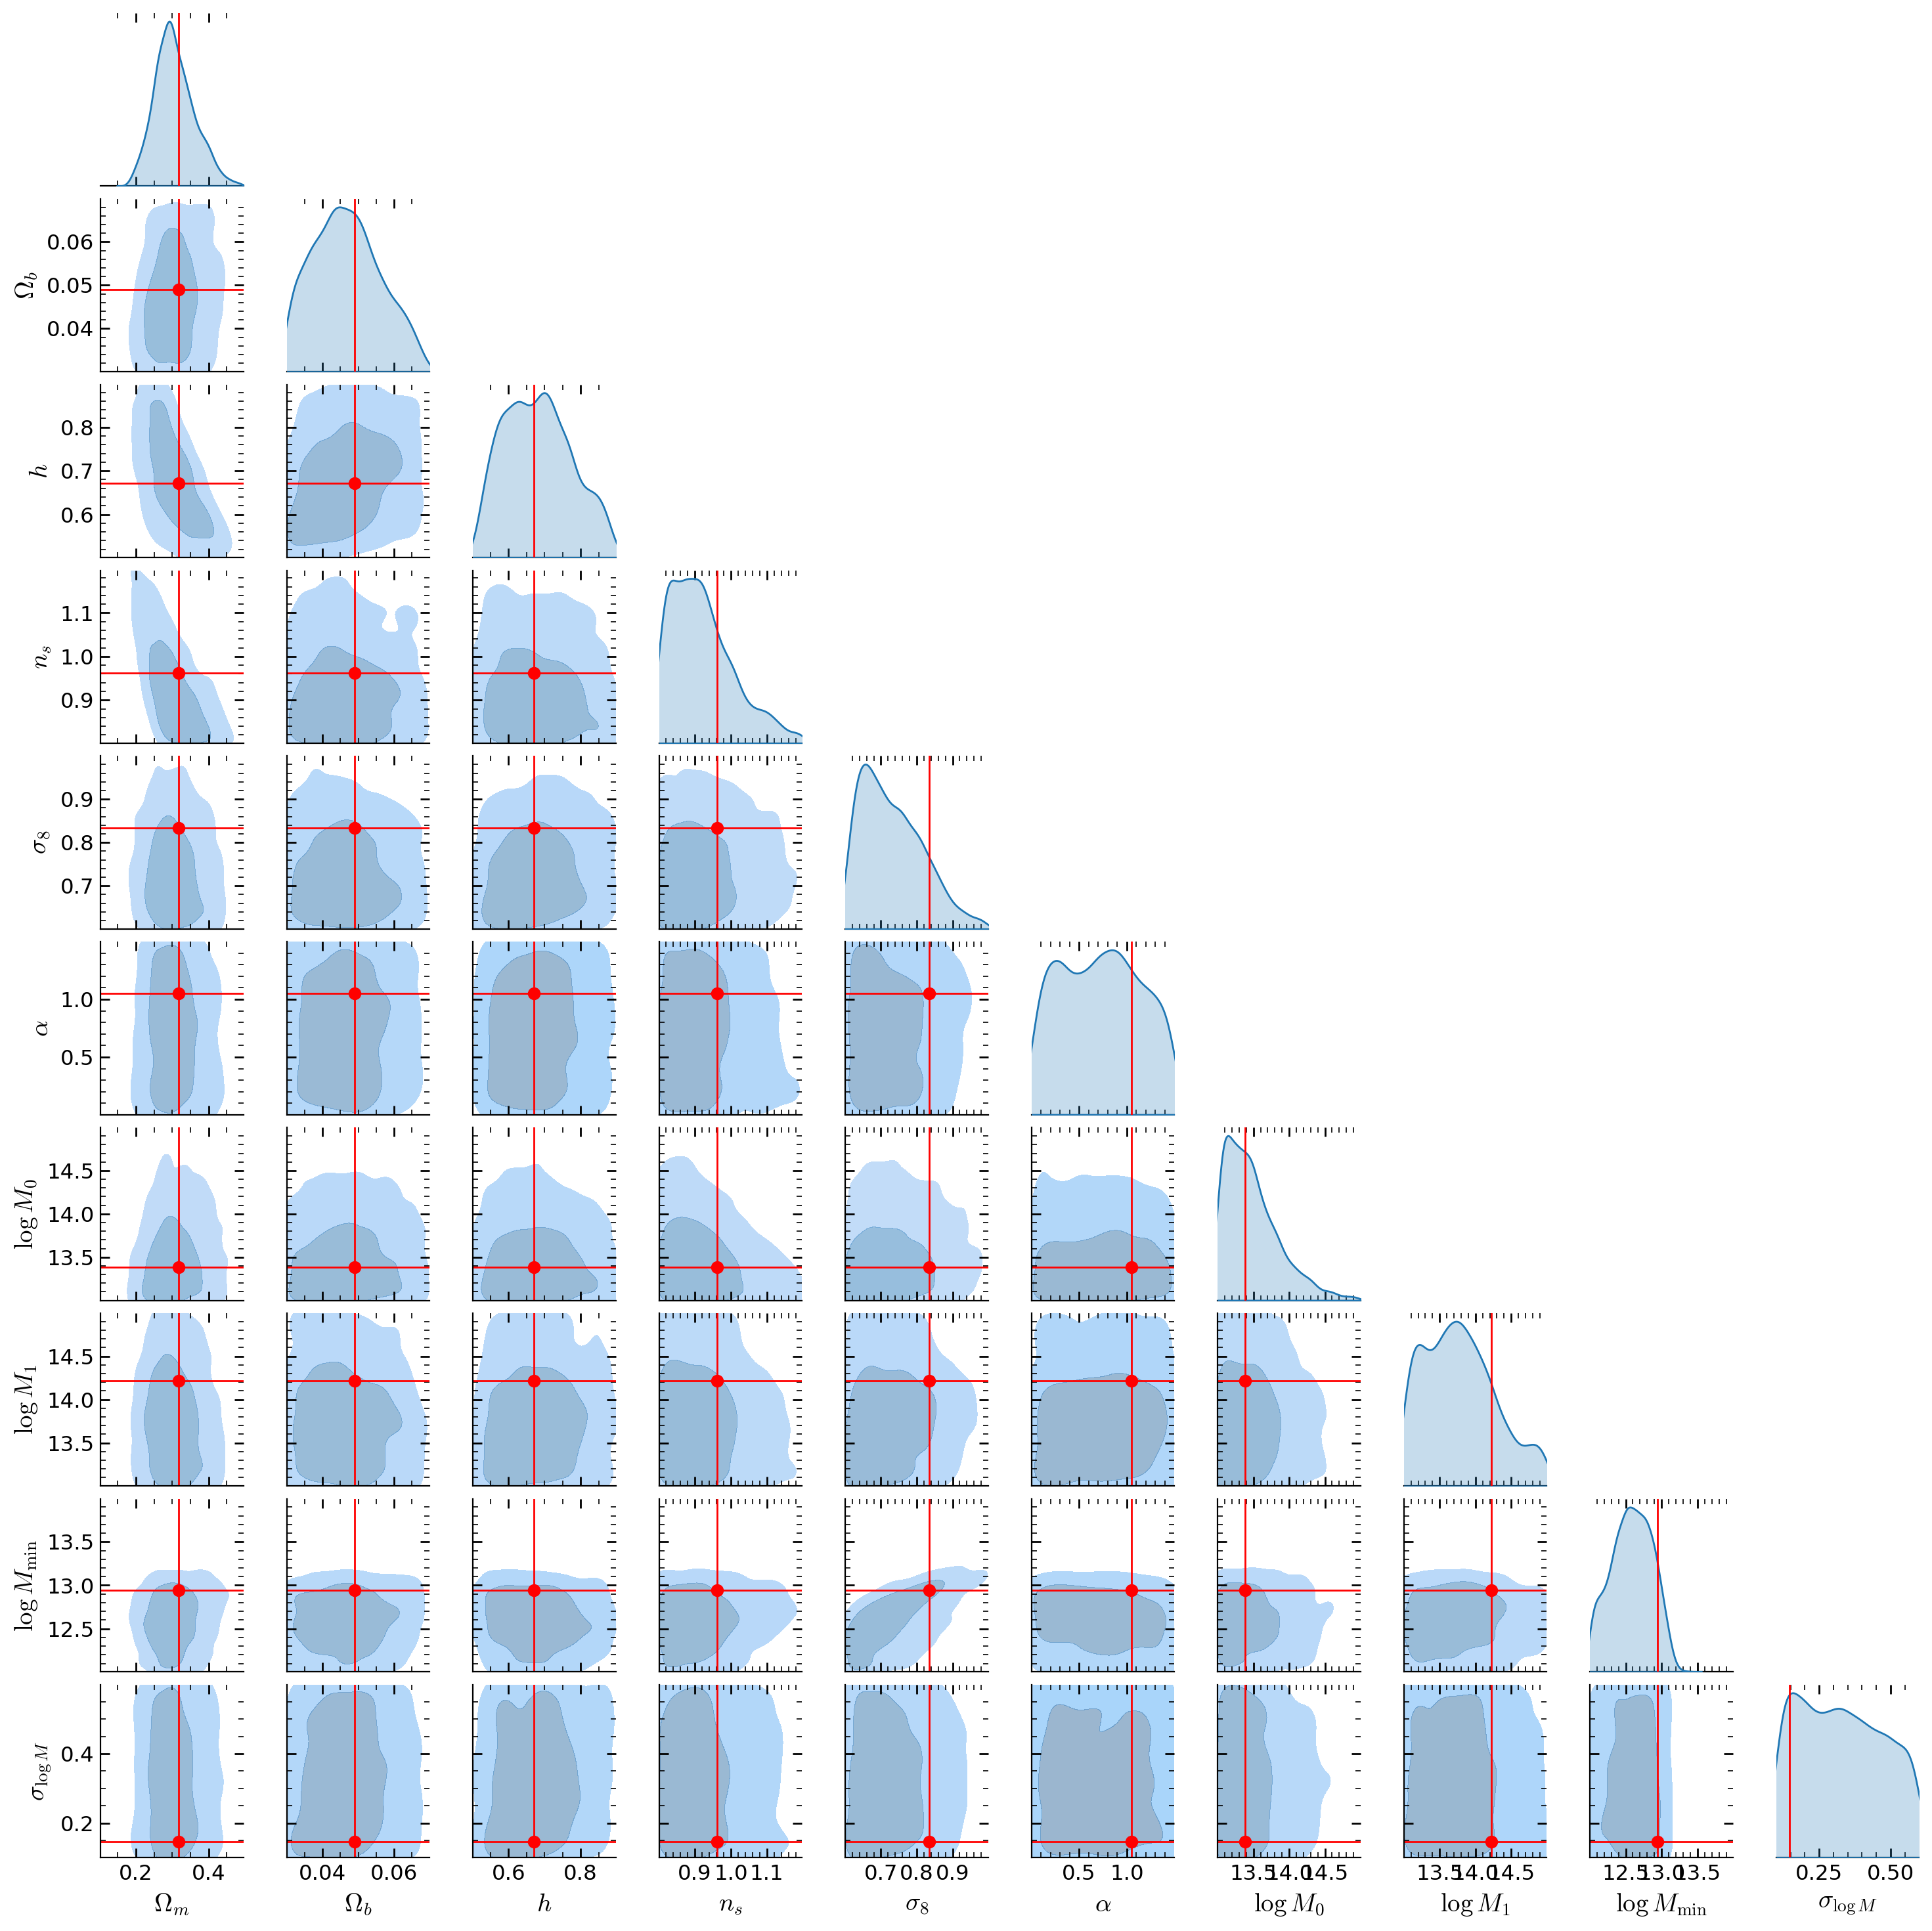

In [15]:
# Predict on a random test point
samp0 = posterior.sample(x=xin, shape=(2000,)).to('cpu')
samp0 = pd.DataFrame(samp0, columns=names)


def plot_true_vals(grid, true_vals, **kwargs):
    for i, val in enumerate(true_vals):
        grid.diag_axes[i].axvline(val, **kwargs)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.axvline(true_vals[j], **kwargs)
                ax.axhline(val, **kwargs)
                ax.plot(true_vals[j], val, 'o', **kwargs)


def set_boundaries(grid, prior_range):
    for i, (x, y) in enumerate(prior_range):
        grid.diag_axes[i].set_xlim(x, y)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.set_ylim(x, y)
                ax.set_xlim(*prior_range[j])


g = sns.pairplot(
    samp0,
    vars=names,
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5
    # plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True},  # for kde plot
)

plot_true_vals(g, trueparams, color='r', lw=1)
set_boundaries(g, yrange)

In [20]:
# Load literature
import pandas as pd

# ivanov
iva = pd.read_csv(
    '/anvil/scratch/x-mho1/cmass-ili/literature/processed/ivanov.csv')
iva = iva.drop('chain', axis=1)

# simbig
sbpk = pd.read_csv(
    '/anvil/scratch/x-mho1/cmass-ili/literature/processed/simbig_pk.csv')


# our work
ltu = pd.DataFrame(samp0.values[:, :5], columns=iva.columns)

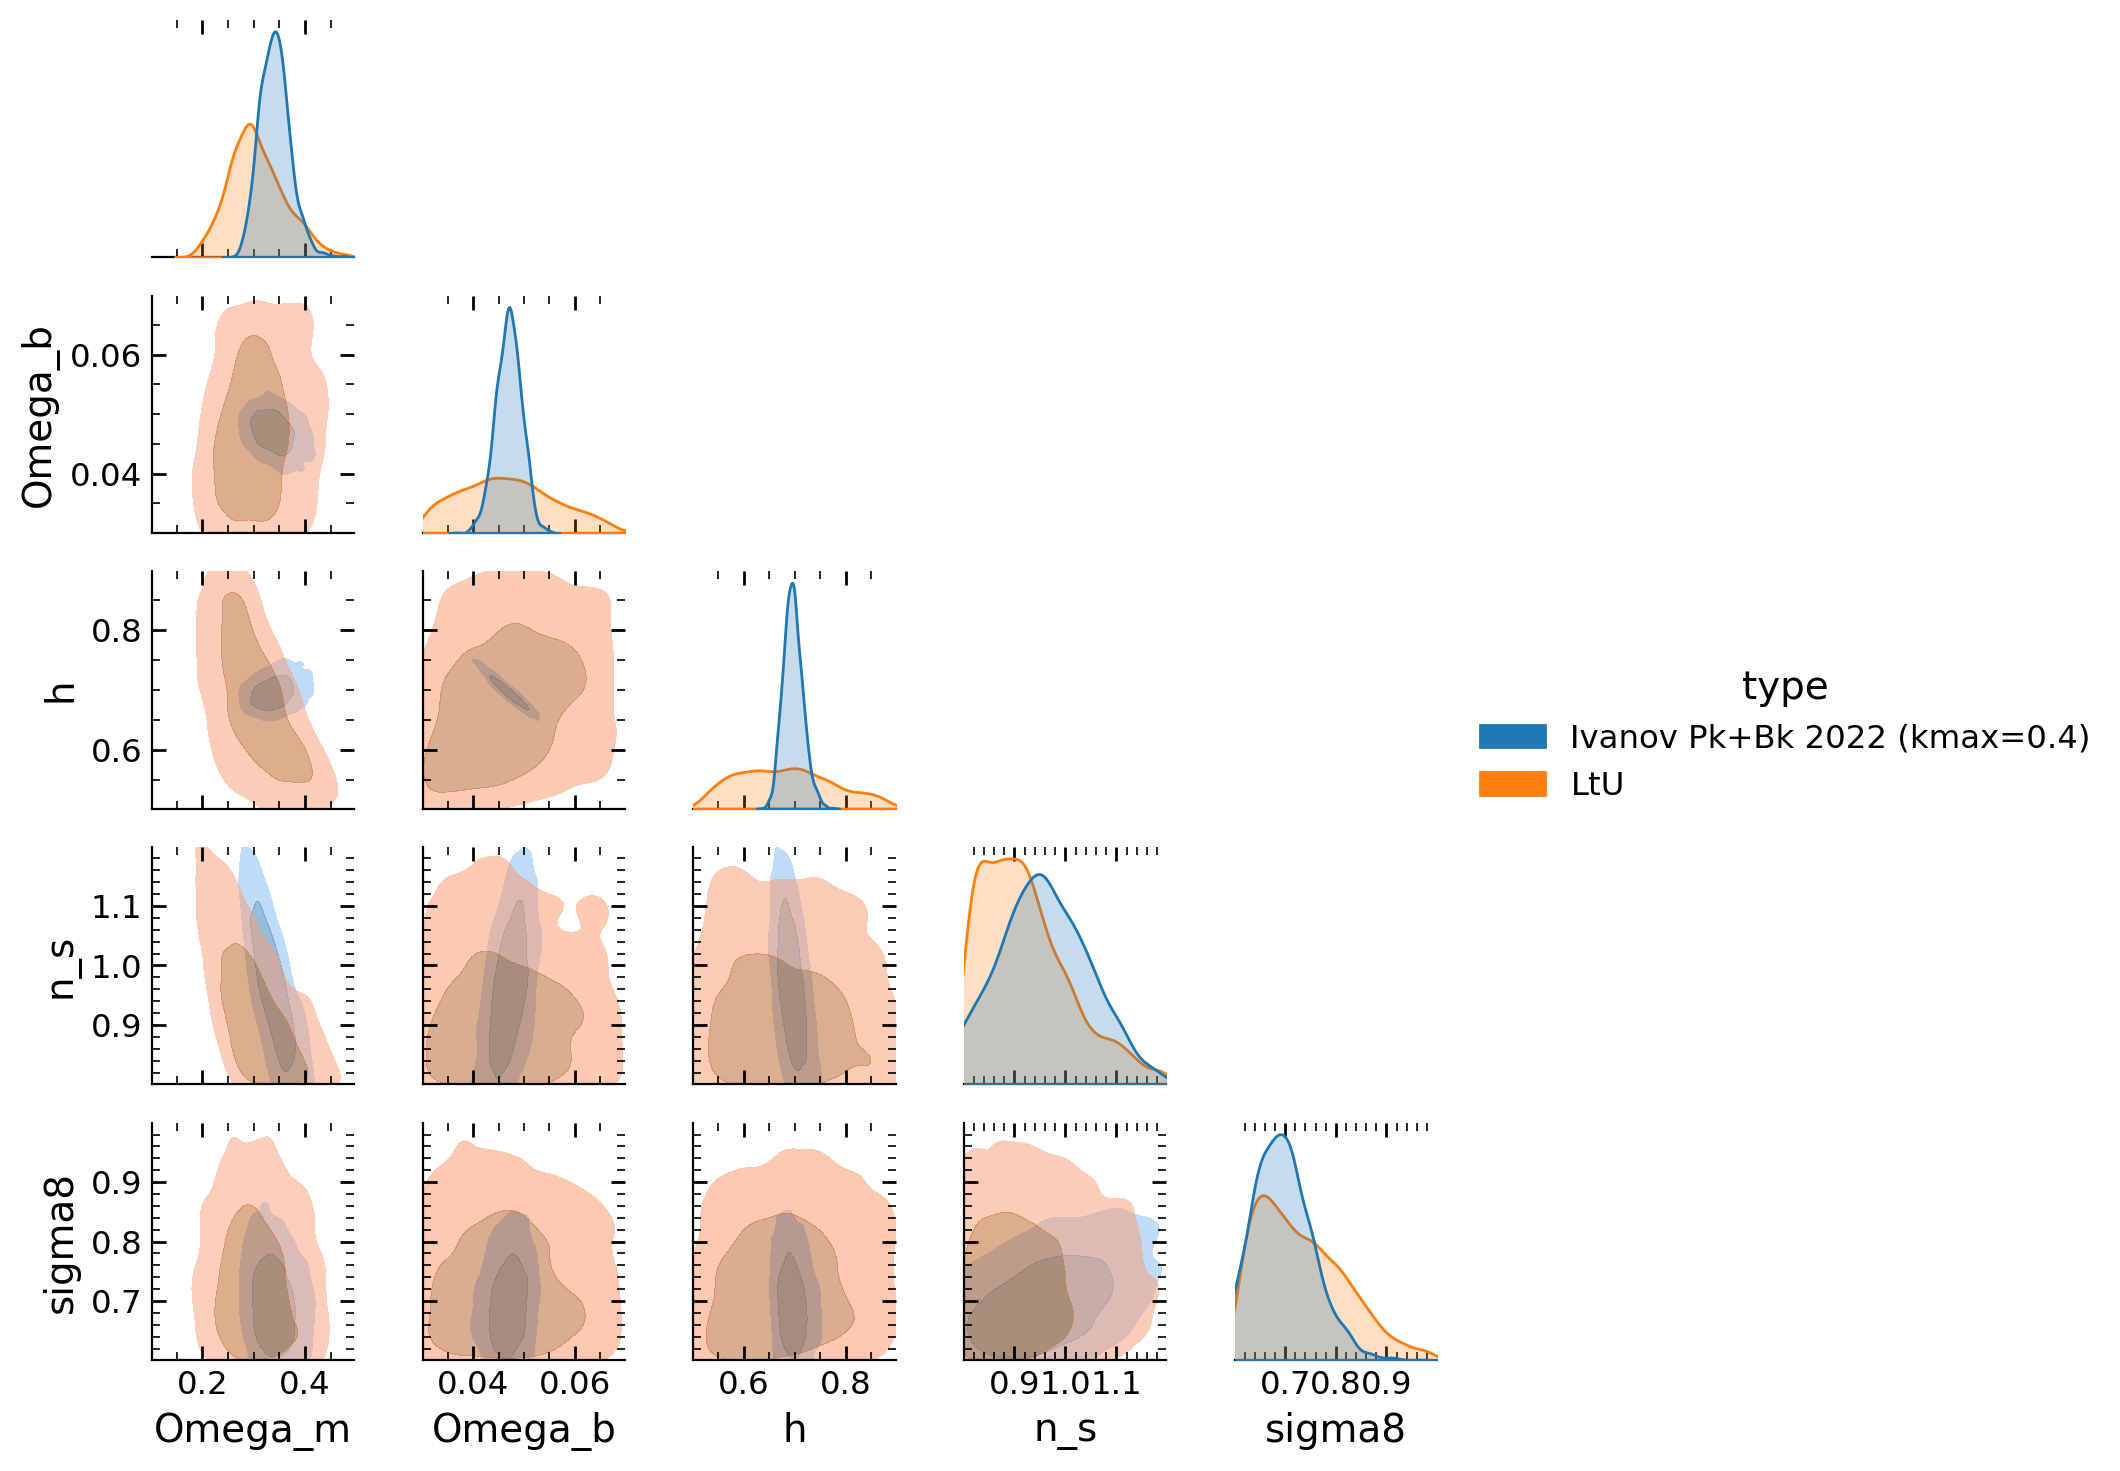

In [22]:
# Create a pairplot of the samples with specified KDE levels and fill, using latex names as axis labels
import seaborn as sns

iva['type'] = 'Ivanov Pk+Bk 2022 (kmax=0.4)'
ltu['type'] = 'LtU'
sbpk['type'] = 'SimBIG Pk (kmax=0.5)'

out = pd.concat([iva[:len(ltu)], ltu]).reset_index(drop=True)

g = sns.pairplot(
    out,
    hue='type',
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5  # Adjust the height to make the figure smaller
)
set_boundaries(g, yrange[:5])

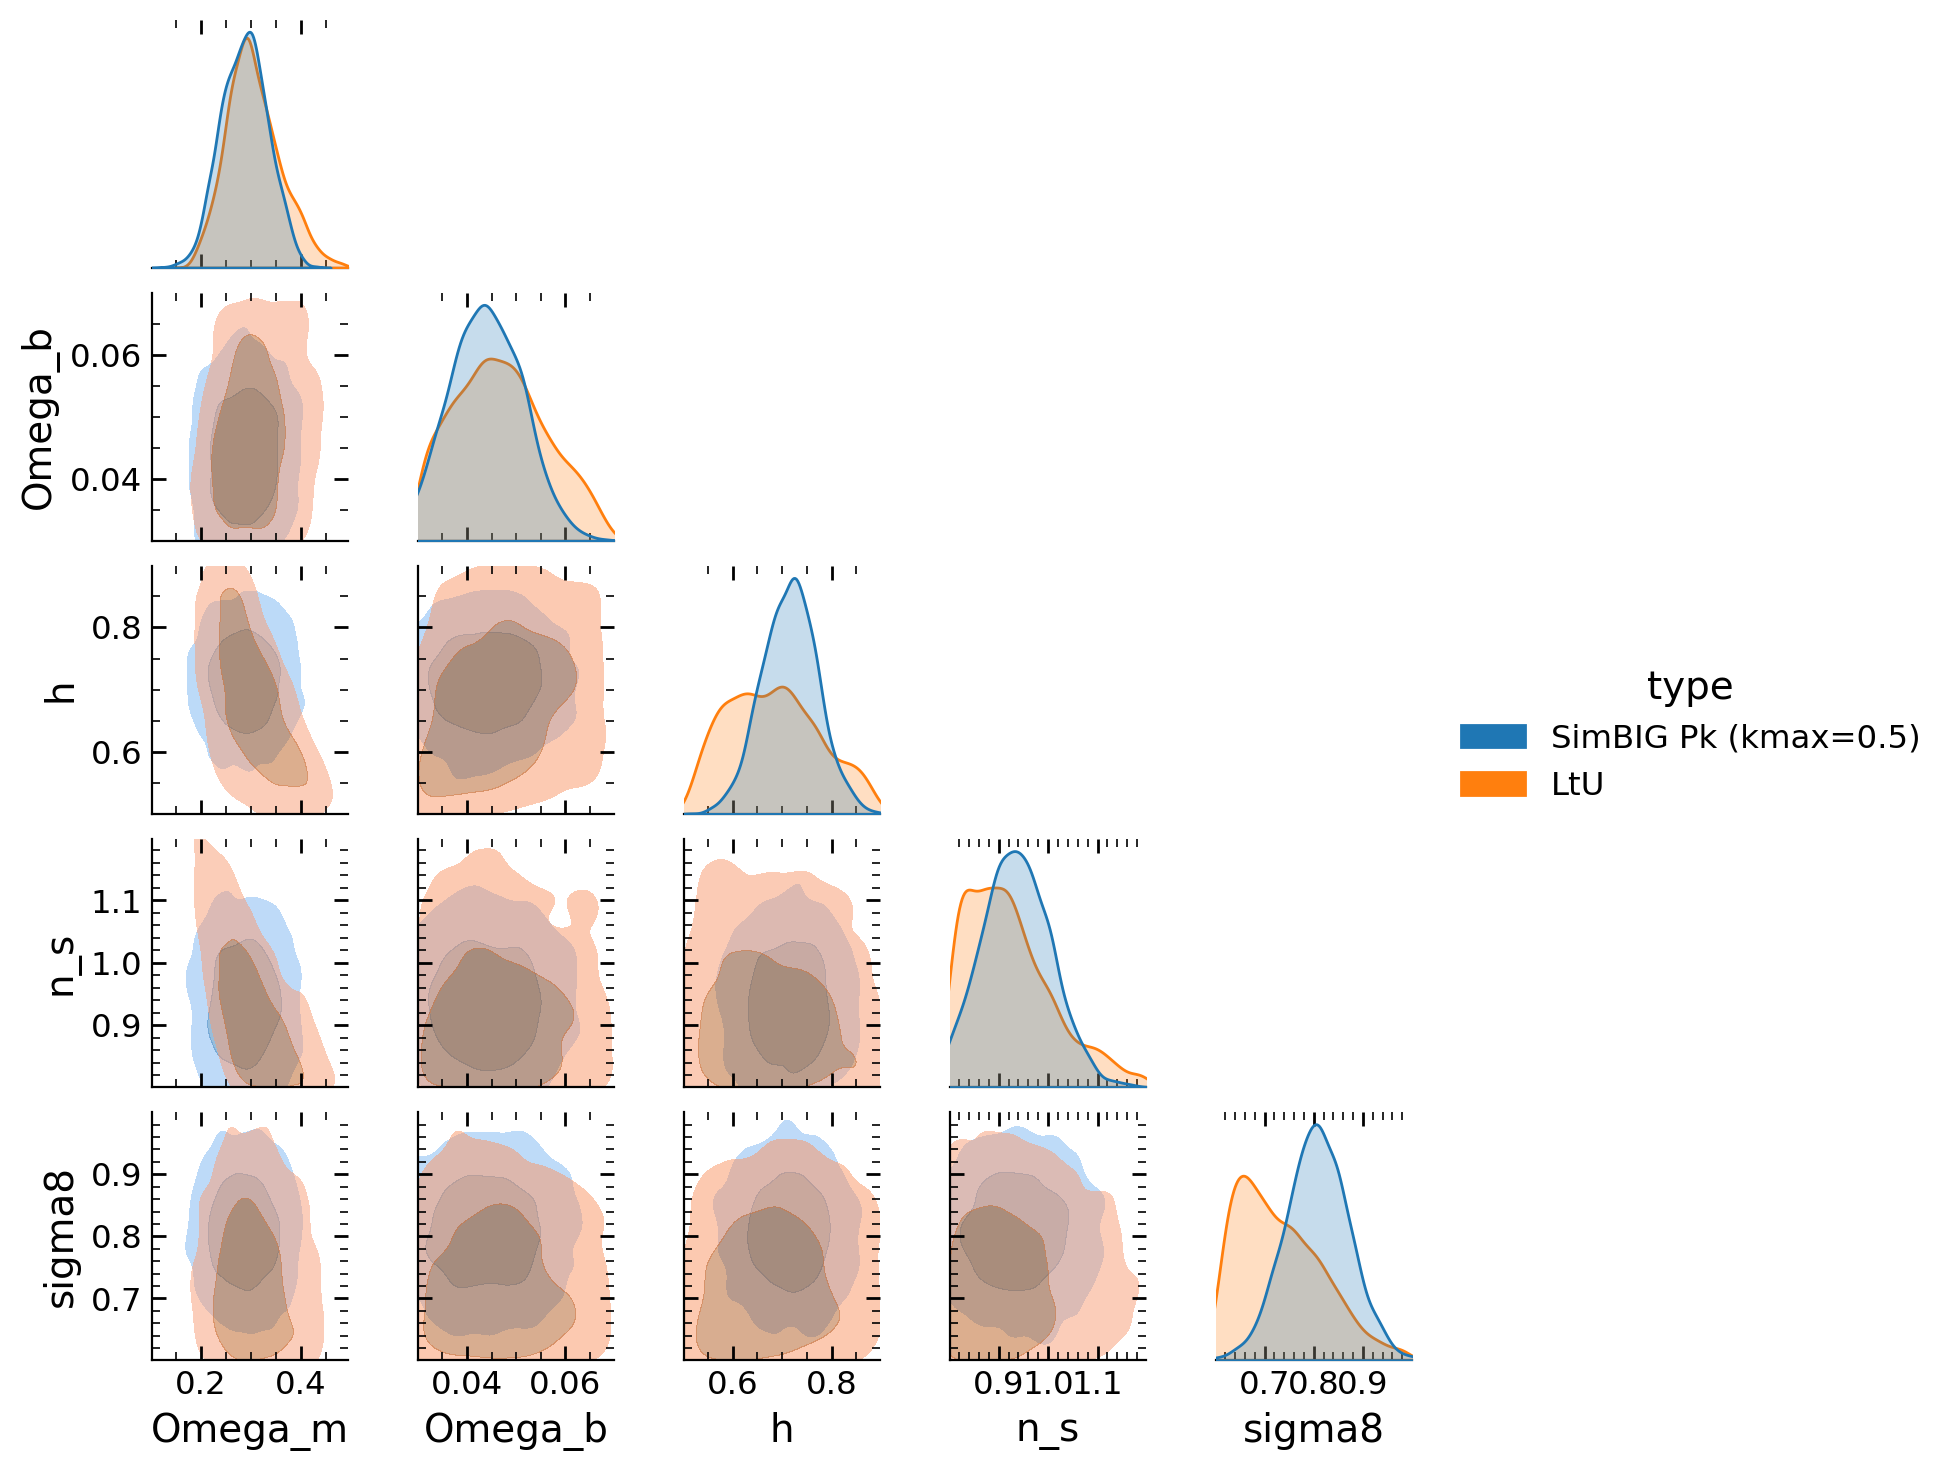

In [23]:
# Create a pairplot of the samples with specified KDE levels and fill, using latex names as axis labels
import seaborn as sns

iva['type'] = 'Ivanov Pk+Bk 2022 (kmax=0.4)'
ltu['type'] = 'LtU'
sbpk['type'] = 'SimBIG Pk (kmax=0.5)'

out = pd.concat([sbpk[:len(ltu)], ltu]).reset_index(drop=True)

g = sns.pairplot(
    out,
    hue='type',
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5  # Adjust the height to make the figure smaller
)
set_boundaries(g, yrange[:5])

## Predict across many kcuts and summaries

In [95]:
summaries = ['Pk0', 'Pk2']
tracer = 'halo'

In [97]:
# Load an observed summary
nbody = 'quijote3gpch'
sim = 'nbody'
L, N = 3000, 384
lhid = 2000
# summaries = ['Pk0', 'Pk2']

simpath = join(wdir, nbody, sim, f'L{L}-N{N}', f'{lhid}', 'diag')

summ = {}
# with h5py.File(join(simpath, 'ngc_lightcone/hod20003_aug00000.h5'), 'r') as f:
#     k = f['Pk_k3D'][:]
#     for s in ['Pk0', 'Pk2', 'Pk4']:
#         if s[:2] != 'Pk':
#             raise NotImplementedError
#         Pk = f['Pk'][:, int(s[-1])//2]  # get the pole
#         summ[s] = [{'k': k, 'value': Pk}]
a = f'{2/3:.6f}'
# with h5py.File(join(simpath, 'galaxies/hod20003.h5'), 'r') as f:
#     k = f[a]['Pk_k3D'][:]
#     for s in ['Pk0', 'Pk2', 'Pk4']:
#         if s[:2] != 'Pk':
#             raise NotImplementedError
#         Pk = f[a]['Pk'][:, int(s[-1])//2]  # get the pole
#         summ[s] = [{'k': k, 'value': Pk}]

#     truecosmo = f.attrs['cosmo_params']
#     truehod = f.attrs['HOD_params']
#     trueparams = np.concatenate([truecosmo, truehod])
with h5py.File(join(simpath, 'halos.h5'), 'r') as f:
    k = f[a]['Pk_k3D'][:]
    for s in ['Pk0', 'Pk2', 'Pk4']:
        if s[:2] != 'Pk':
            raise NotImplementedError
        Pk = f[a]['Pk'][:, int(s[-1])//2]  # get the pole
        summ[s] = [{'k': k, 'value': Pk}]

    truecosmo = f.attrs['cosmo_params']
    # truehod = f.attrs['HOD_params']
    trueparams = truecosmo  # np.concatenate([truecosmo, truehod])

# truecosmo = [0.3175, 0.04900, 0.6711, 0.9624, 0.834]

In [98]:
from cmass.infer.loaders import preprocess_Pk


def load_and_predict(summaries=['Pk0', 'Pk2'], kmax=0.1):
    # Specify data dtype
    summary = '+'.join(summaries)
    modelpath = join(save_dir, tracer, summary, f'kmax-{kmax}')
    print(modelpath)

    # Load model posterior
    p = load_posterior(modelpath)

    # Load losses
    summary_file = join(modelpath, 'summary.json')
    with open(summary_file, 'r') as f:
        history = json.load(f)

    # Preprocess observations
    xin = []
    for s in summaries:
        if s == 'Pk0':
            xs = preprocess_Pk(summ[s], kmax, monopole=True)
        else:
            xs = preprocess_Pk(summ[s], kmax, monopole=False, norm=summ['Pk0'])
        xin.append(xs)
    xin = np.array(xin).flatten()
    print(xin.shape)

    # Predict
    sampobs = p.sample(x=xin, shape=(1000,)).to('cpu')
    return sampobs, history

INFO:root:Sampling models with [454, 546] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.2
(190,)


Drawing 454 posterior samples: 822it [00:00, 17234.71it/s]            
Drawing 546 posterior samples: 792it [00:00, 51762.17it/s]            
INFO:root:Sampling models with [574, 426] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.3
(284,)


Drawing 574 posterior samples: 1068it [00:00, 21323.31it/s]           
Drawing 426 posterior samples: 734it [00:00, 47748.30it/s]            
INFO:root:Sampling models with [595, 405] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.4
(380,)


Drawing 595 posterior samples: 1085it [00:00, 20854.27it/s]           
Drawing 405 posterior samples: 645it [00:00, 40629.05it/s]            
INFO:root:Sampling models with [572, 428] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.5
(476,)


Drawing 572 posterior samples: 909it [00:00, 16591.12it/s]            
Drawing 428 posterior samples: 689it [00:00, 39331.41it/s]            


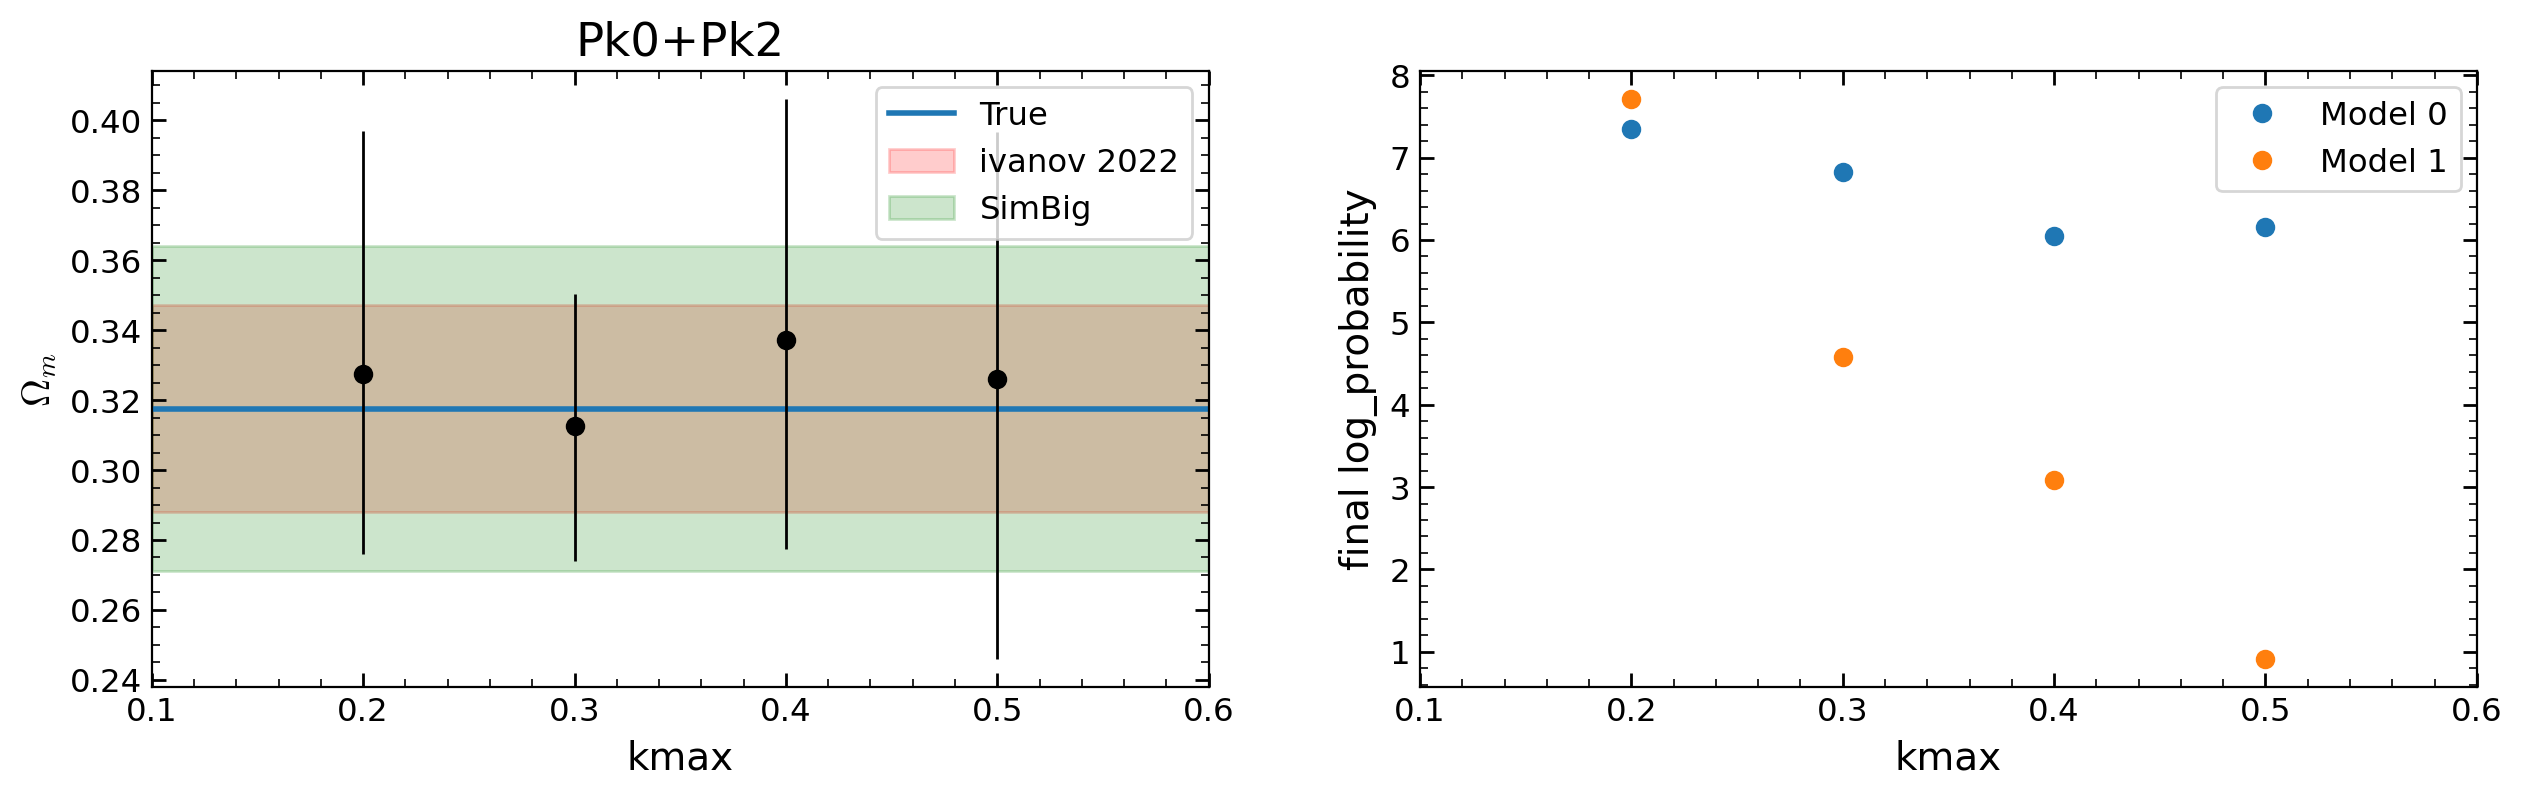

In [99]:
# Omega_m
pind = 0

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

for k in [0.2, 0.3, 0.4, 0.5]:
    sampobs, hist = load_and_predict(summaries, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(k, percs[1, pind], 'ko')
    ax.errorbar(k, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        ax2.plot(k, hist[j]['validation_log_probs'][-1], 'o',
                 label=f'Model {j}' if k == 0.2 else None,
                 c=f'C{j}')
ax.set(xlabel='kmax', ylabel=names[pind])
ax.legend()
ax.set_xlim(0.1, 0.6)
ax.set_title('+'.join(summaries))
ax2.set(xlabel='kmax', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [454, 546] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.2
(190,)


Drawing 454 posterior samples: 804it [00:00, 16848.89it/s]            
Drawing 546 posterior samples: 812it [00:00, 53452.43it/s]            
INFO:root:Sampling models with [574, 426] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.3
(284,)


Drawing 574 posterior samples: 1057it [00:00, 21057.28it/s]           
Drawing 426 posterior samples: 742it [00:00, 48377.51it/s]            
INFO:root:Sampling models with [595, 405] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.4
(380,)


Drawing 595 posterior samples: 1080it [00:00, 20798.77it/s]           
Drawing 405 posterior samples: 639it [00:00, 41265.61it/s]            
INFO:root:Sampling models with [572, 428] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.5
(476,)


Drawing 572 posterior samples: 881it [00:00, 16950.14it/s]            
Drawing 428 posterior samples: 674it [00:00, 38542.81it/s]            


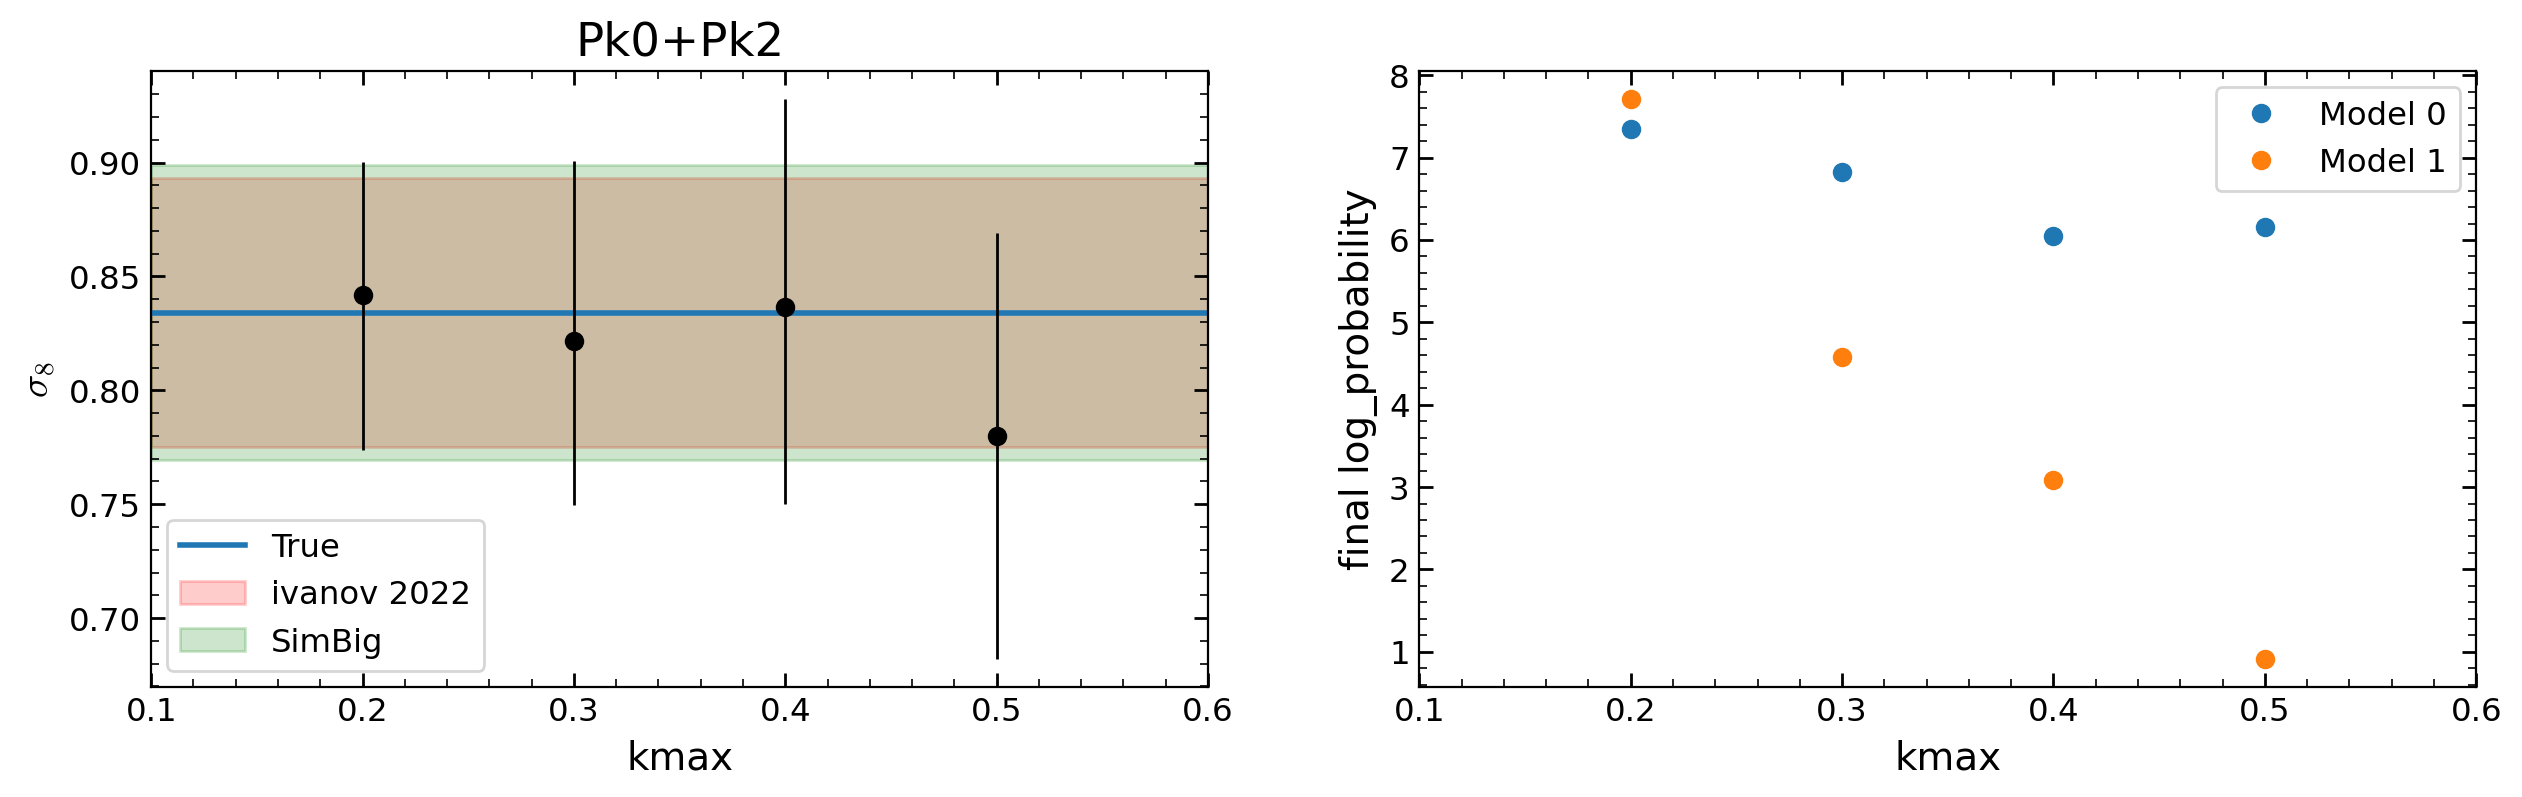

In [100]:
# sigma_8
pind = 4

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

for k in [0.2, 0.3, 0.4, 0.5]:
    sampobs, hist = load_and_predict(summaries, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(k, percs[1, pind], 'ko')
    ax.errorbar(k, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        ax2.plot(k, hist[j]['validation_log_probs'][-1], 'o',
                 label=f'Model {j}' if k == 0.2 else None,
                 c=f'C{j}')
ax.set(xlabel='kmax', ylabel=names[pind])
ax.legend()
ax.set_xlim(0.1, 0.6)
ax.set_title('+'.join(summaries))
ax2.set(xlabel='kmax', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [853, 147] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.2
(220,)


Drawing 853 posterior samples: 1448it [00:00, 9827.72it/s]            
Drawing 147 posterior samples: 178it [00:00, 7498.63it/s]             
INFO:root:Sampling models with [812, 188] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.3
(332,)


Drawing 812 posterior samples: 1433it [00:00, 9898.45it/s]            
Drawing 188 posterior samples: 210it [00:00, 8101.43it/s]             


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.4


INFO:root:Sampling models with [895, 105] samples each.


(444,)


Drawing 895 posterior samples: 1699it [00:00, 10981.85it/s]           
Drawing 105 posterior samples: 145it [00:00, 4002.70it/s]             

/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.5



INFO:root:Sampling models with [953, 47] samples each.


(556,)


Drawing 953 posterior samples: 1811it [00:00, 11282.25it/s]           
Drawing 47 posterior samples: 66it [00:00, 1959.61it/s]             


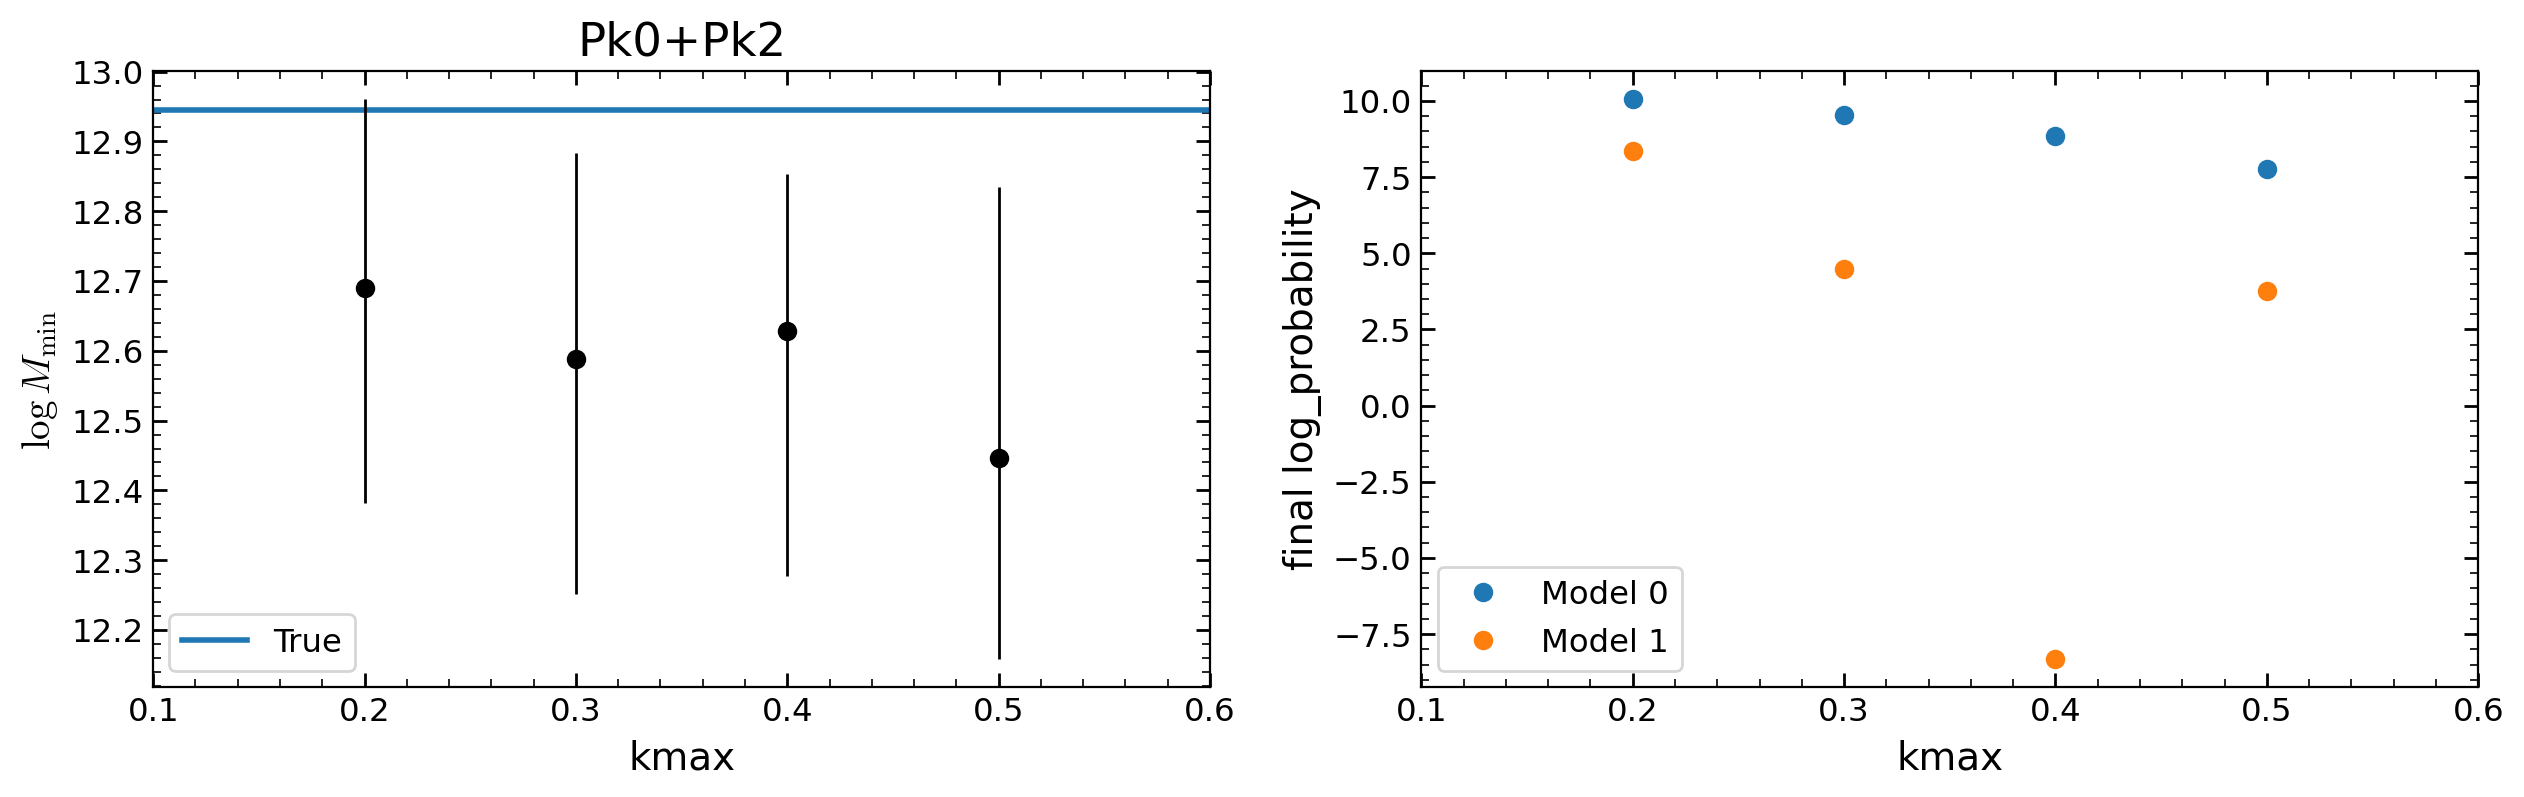

In [67]:
# logMmin
pind = 8

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
# std = iva.iloc[:,pind].std()
# ax.fill_between([0.1, 0.6],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='r', label='ivanov 2022')
# std = sbpk.iloc[:,pind].std()
# ax.fill_between([0.1, 0.6],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

for k in [0.2, 0.3, 0.4, 0.5]:
    sampobs, hist = load_and_predict(summaries, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(k, percs[1, pind], 'ko')
    ax.errorbar(k, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        ax2.plot(k, hist[j]['validation_log_probs'][-1], 'o',
                 label=f'Model {j}' if k == 0.2 else None,
                 c=f'C{j}')
ax.set(xlabel='kmax', ylabel=names[pind])
ax.legend()
ax.set_xlim(0.1, 0.6)
ax.set_title('+'.join(summaries))
ax2.set(xlabel='kmax', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [874, 126] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0/kmax-0.4
(222,)


Drawing 874 posterior samples: 1377it [00:00, 9044.77it/s]            
Drawing 126 posterior samples: 174it [00:00, 3778.05it/s]             
INFO:root:Sampling models with [895, 105] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.4
(444,)


Drawing 895 posterior samples: 1703it [00:00, 10878.02it/s]           
Drawing 105 posterior samples: 100%|██████████| 105/105 [00:00<00:00, 1207.20it/s]
INFO:root:Sampling models with [1000, 0] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.4
(666,)


Drawing 1000 posterior samples: 1682it [00:00, 8495.19it/s]                         


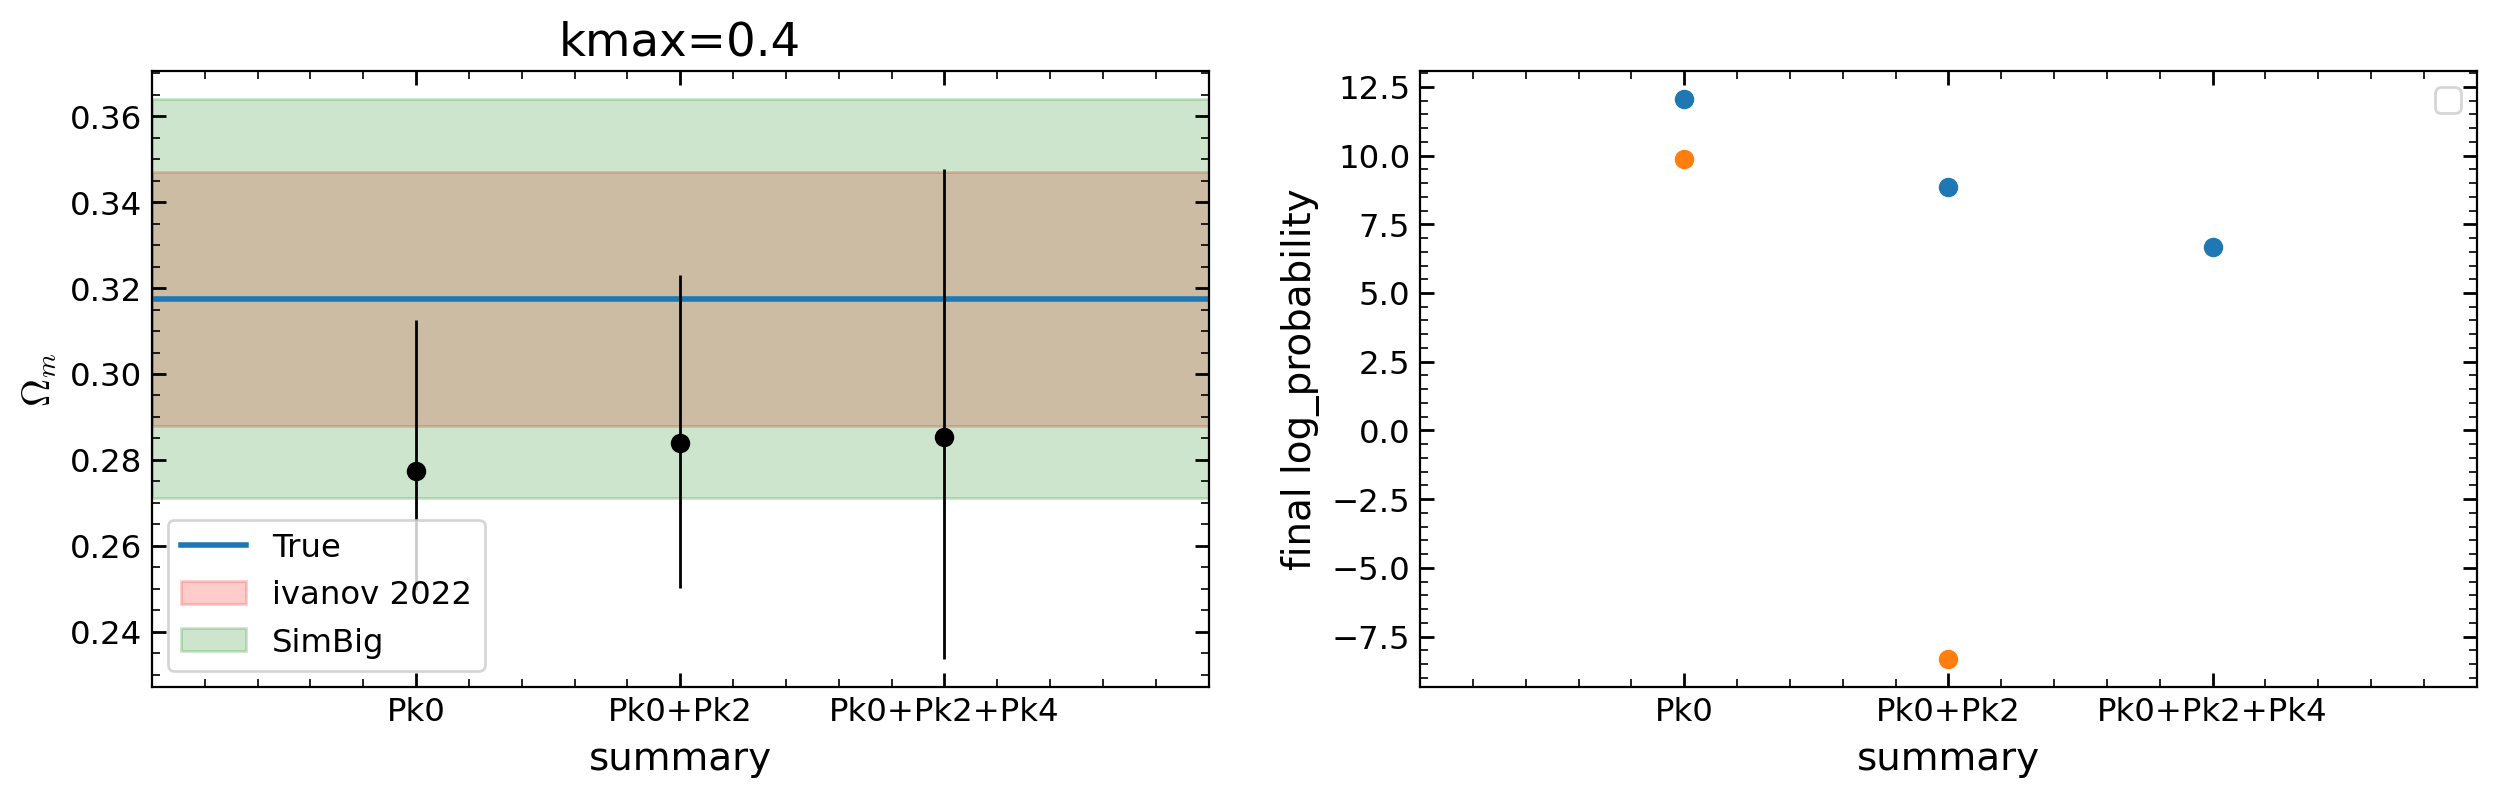

In [79]:
# Omega_m
pind = 0

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

slist = [['Pk0'], ['Pk0', 'Pk2'], ['Pk0', 'Pk2', 'Pk4']]
for i, s in enumerate(slist):
    k = 0.4
    sampobs, hist = load_and_predict(s, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(i, percs[1, pind], 'ko')
    ax.errorbar(i, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        y = hist[j]['validation_log_probs'][-1]
        if y > -10:
            ax2.plot(i, y, 'o',
                     label=f'Model {j}' if k == 0.2 else None,
                     c=f'C{j}')
ax.set(xlabel='summary', ylabel=names[pind])
ax.legend()
ax.set_xlim(-1, 3)
ax.set_xticks(range(len(slist)))
ax.set_xticklabels(['+'.join(s) for s in slist])
ax.set_title(f'kmax={k}')
ax2.set(xlabel='summary', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [874, 126] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0/kmax-0.4
(222,)


Drawing 874 posterior samples: 1372it [00:00, 8680.19it/s]            
Drawing 126 posterior samples: 128it [00:00, 3677.93it/s]             
INFO:root:Sampling models with [895, 105] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.4
(444,)


Drawing 895 posterior samples: 1714it [00:00, 10559.12it/s]           
Drawing 105 posterior samples: 136it [00:00, 3783.69it/s]             
INFO:root:Sampling models with [1000, 0] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.4
(666,)


Drawing 1000 posterior samples: 1674it [00:00, 9345.91it/s]             


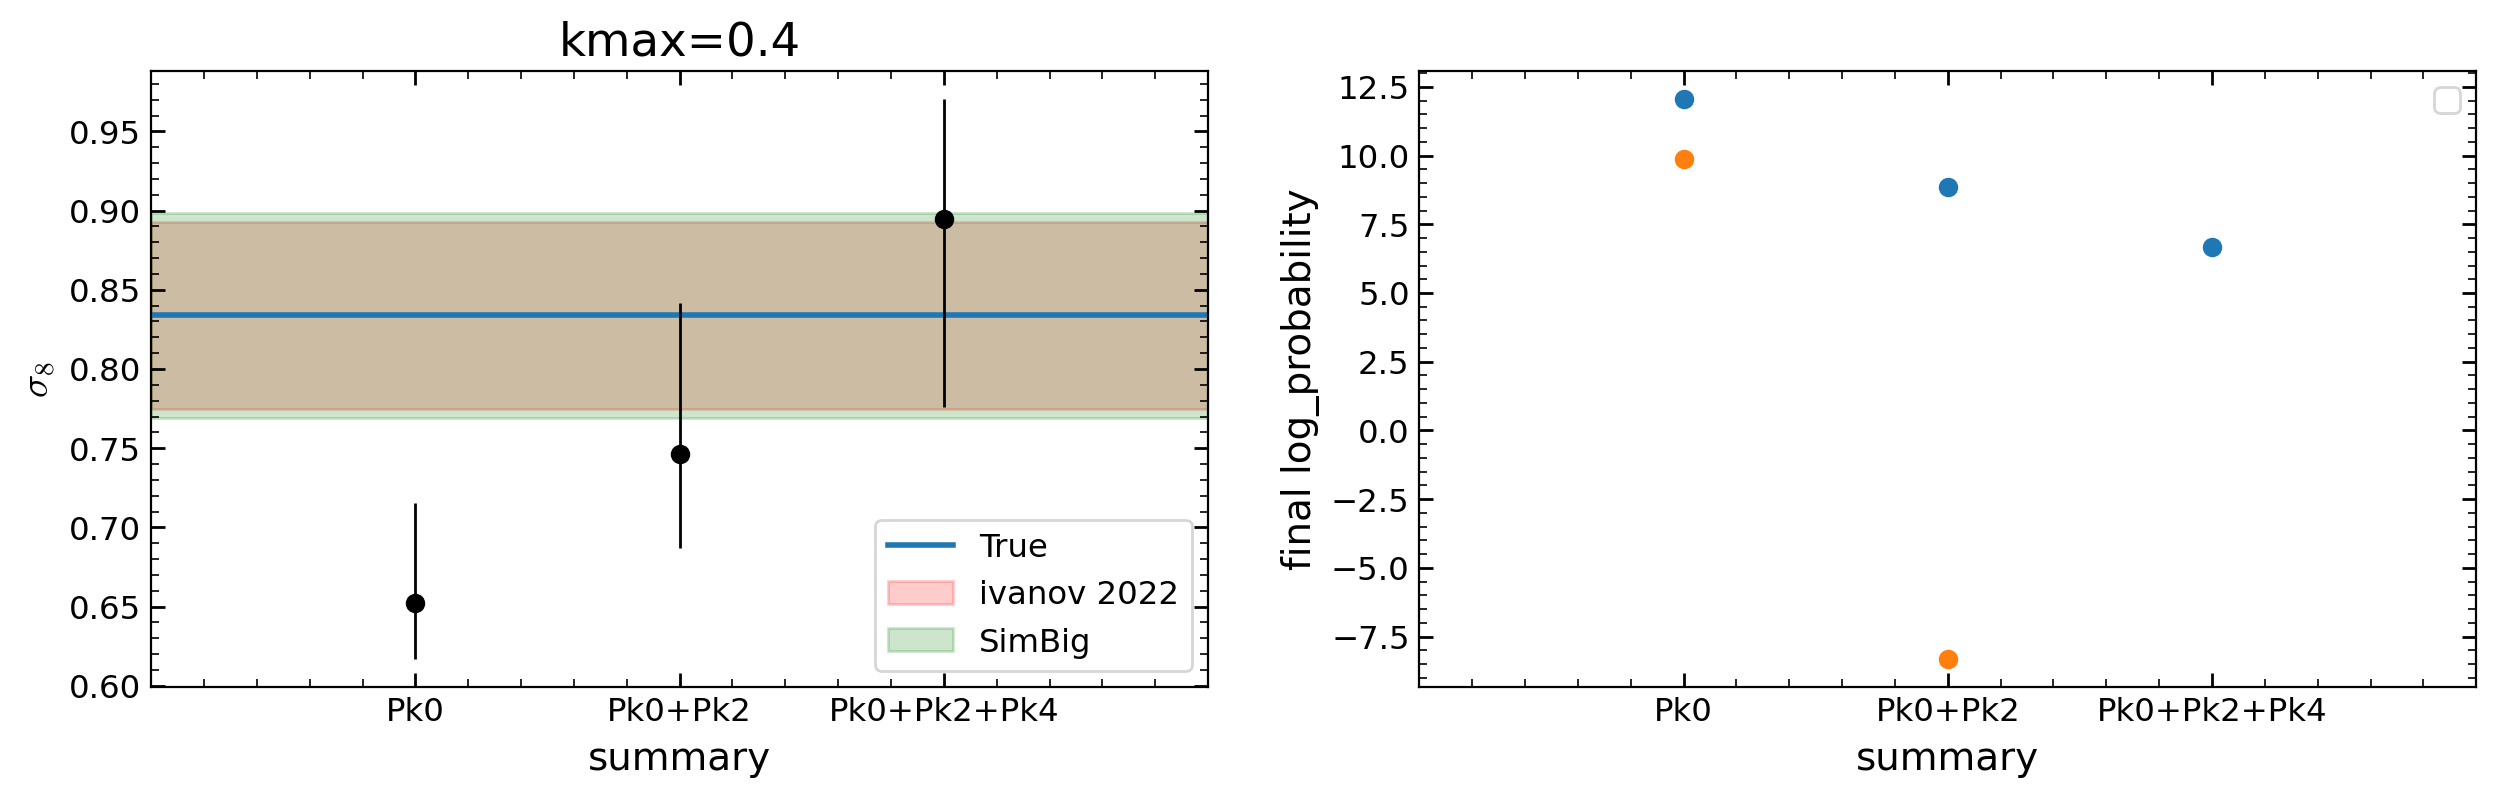

In [77]:
# sigma8
pind = 4

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

slist = [['Pk0'], ['Pk0', 'Pk2'], ['Pk0', 'Pk2', 'Pk4']]
for i, s in enumerate(slist):
    k = 0.4
    sampobs, hist = load_and_predict(s, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(i, percs[1, pind], 'ko')
    ax.errorbar(i, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        y = hist[j]['validation_log_probs'][-1]
        if y > -10:
            ax2.plot(i, y, 'o',
                     label=f'Model {j}' if k == 0.2 else None,
                     c=f'C{j}')
ax.set(xlabel='summary', ylabel=names[pind])
ax.legend()
ax.set_xlim(-1, 3)
ax.set_xticks(range(len(slist)))
ax.set_xticklabels(['+'.join(s) for s in slist])
ax.set_title(f'kmax={k}')
ax2.set(xlabel='summary', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [874, 126] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0/kmax-0.4
(222,)


Drawing 874 posterior samples: 1362it [00:00, 9113.50it/s]            
Drawing 126 posterior samples:  89%|████████▉ | 112/126 [00:00<00:00, 3231.34it/s]
INFO:root:Sampling models with [895, 105] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.4
(444,)


Drawing 895 posterior samples: 1707it [00:00, 10855.35it/s]           
Drawing 105 posterior samples: 110it [00:00, 4678.44it/s]             


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.4


INFO:root:Sampling models with [1000, 0] samples each.


(666,)


Drawing 1000 posterior samples: 1709it [00:00, 9988.34it/s]             


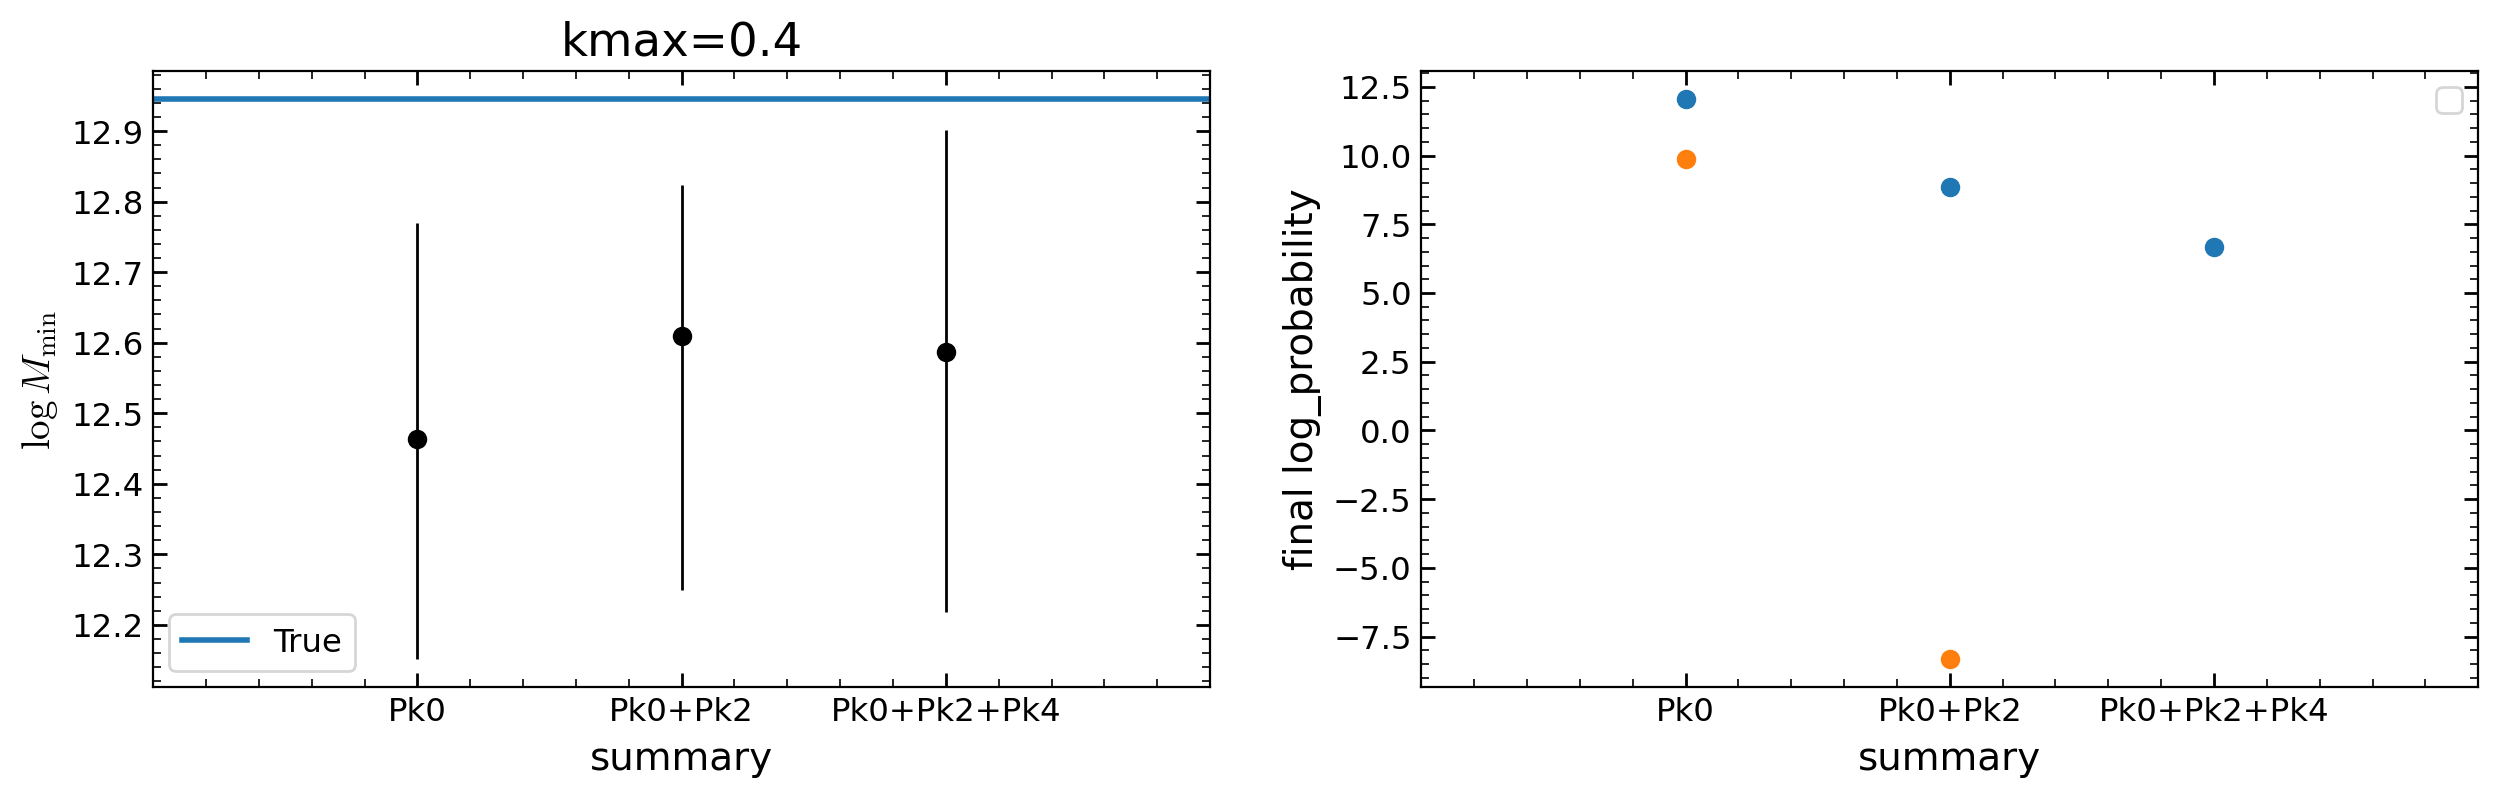

In [80]:
# logMmin
pind = 8

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
# std = iva.iloc[:,pind].std()
# ax.fill_between([-1, 3],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='r', label='ivanov 2022')
# std = sbpk.iloc[:,pind].std()
# ax.fill_between([-1, 3],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

slist = [['Pk0'], ['Pk0', 'Pk2'], ['Pk0', 'Pk2', 'Pk4']]
for i, s in enumerate(slist):
    k = 0.4
    sampobs, hist = load_and_predict(s, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(i, percs[1, pind], 'ko')
    ax.errorbar(i, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        y = hist[j]['validation_log_probs'][-1]
        if y > -10:
            ax2.plot(i, y, 'o',
                     label=f'Model {j}' if k == 0.2 else None,
                     c=f'C{j}')
ax.set(xlabel='summary', ylabel=names[pind])
ax.legend()
ax.set_xlim(-1, 3)
ax.set_xticks(range(len(slist)))
ax.set_xticklabels(['+'.join(s) for s in slist])
ax.set_title(f'kmax={k}')
ax2.set(xlabel='summary', ylabel='final log_probability')
ax2.legend()

## Scratch